This note book was used for the bulk of the linear mixed models presented in the manuscript.

In [1]:
library(tidyverse)
library(lmerTest)
library(lme4)

emmeans::emm_options(pbkrtest.limit = 7328, lmerTest.limit = 7328)
options(contrasts = c("contr.sum","contr.poly"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘lmerTest’ was built under R version 3.6.3”Loading required package: lme4
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [2]:
# stolen from JEP
# read in metadata
vif_meta <- read.csv("vitis_ionomics_meta.csv")
# read in data
vif_data <- read.csv("vif_k10.csv")
vif_data <- vif_data  %>% rename(B=B11, Na=Na23, Mg=Mg26, Al=Al27, P=P31, S=S34, K=K39, Ca=Ca44,
                                 Fe=Fe54, Mn=Mn55, Co=Co59, Ni=Ni60, Cu=Cu63, Zn=Zn66, As=As75,
                                 Se=Se78, Rb=Rb85, Sr=Sr88, Mo=Mo98, Cd=Cd111)
# Merge metadata and data to new df
vif <- merge(vif_meta, vif_data, on='samplename')
# These are all the duplciate values
dupes <- as.data.frame(table(vif$samplename)[table(vif$samplename) > 1])
dupes
# Set row number to sample name- for consistency
rownames(vif) <- vif$samplename
vif$row <- as.factor(vif$row)
vif$block <- as.factor(vif$block)
vif$year <- as.factor(vif$year)
# remove when there is a Z for replicate (invalid data)
vif <- vif[-c(which(vif$replicate == 'Z')), ]
# remove when leafposition is set to F (invalid data)
vif <- vif[-c(which(vif$leafpos == 'F')), ]
# capitalize the Z in leafposition (change to valid data)
vif$leafpos[which(vif$leafpos == 'z')] <- 'Z'
# refactor
vif$leafpos <- factor(vif$leafpos, levels=c('X', 'Y', 'Z'))
vif$rootstock <- factor(vif$rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))
vif$treatment <- factor(vif$treatment, levels=c('None', 'RDI', 'Full'))
vif$phenology <- factor(vif$phenology, levels=c('anthesis','veraison','harvest'), labels=c('Anthesis', 'Veraison', 'Harvest'))

rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
p_palette <- c('orchid1', 'purple1', 'darkorchid4')
i_palette <- c('grey', 'lightblue', 'darkblue')
b_palette <- c('#ffd4a3', '#ffaa5e', '#d08159')
y_palette <- c('dodgerblue4', 'springgreen1', '#cc77ff')#'#f0b4d2')
l_palette <- c(rgb(145,102,189,maxColorValue=255),rgb(178,76,76,maxColorValue=255),rgb(0,146,146,maxColorValue=255),rgb(255,182,119,maxColorValue=255))
r_palette <- viridisLite::viridis(9)

table(vif$samplename)[table(vif$samplename) > 1]


## 1. Write the back-transformed data for later use

The data given to me by JEP are transformed using python: sklearn.preprocessing.StandardScaler(). Using the transformed data, JEP filled in missing values using a KNN imputaion framework. While I want to keep the values transformed for the sake of the linear models, when we discuss them, then need to be in concentration space. This just uses the means and variances from JEP's StandardScaler object, and write the back transformation. 

In [3]:
# test back transform

test <- vif %>%
  #column_to_rownames('samplename') %>% 
  select(B:Cd)

test_dict <- read.csv('backtransform_zscores.csv')
rownames(test_dict) <- colnames(test)

test <- t(test) 

new_df <- data.frame(ions=rownames(test))
for (sample in colnames(test)){
    new_df[,sample] <- (test[,sample] * sqrt(test_dict$var)) + test_dict$mean
}

rownames(new_df) <- new_df$ions
new_df$ions <- NULL
new_df <- t(new_df)
dim(new_df)

write.csv(new_df, file='1719_ionomics_BACKTRANSFORMED.csv')

[1] 7328   20

In [61]:
# was testing samples to make sure the values matches and the NAs were transformed to a reasonable point
# raw <- read.csv('vitis_ionomics_data.csv')
# raw$Li7 <- NULL
# raw <- raw[(raw$samplename %in% rownames(new_df)),]
# raw <- raw[rowSums(is.na(raw)) > 0,]
# raw

In [62]:
# was testing samples to make sure the values matches and the NAs were transformed to a reasonable point
# new_df[rownames(new_df) %in% raw$samplename,]

## 2. test emmeans

This is just a test to make sure. understand what is heppening in emmeans. Mainly, is it returning an adjusted mean or a non-adjusted mean?

To do this, I fit a model to Ni only using rootstock as a model factor, and usinf the full design from the 2017 leaf paper - this time allowing year to interact with the larger design. 

In [4]:
d <- vif

In [5]:
d <- select(d, Ni, samplename, year:rootstock)
d$vine_id <- paste(d$row, d$cell, d$replicate, sep='')
head(d)

,Ni,samplename,year,phenology,row,replicate,cell,leafpos,treatment,block,rootstock,vine_id
2017_anthesis_10_A_1_X,-0.2315964,2017_anthesis_10_A_1_X,2017,Anthesis,10,1,A,X,Full,1,3309C,10A1
2017_anthesis_10_A_1_Y,-0.5529190,2017_anthesis_10_A_1_Y,2017,Anthesis,10,1,A,Y,Full,1,3309C,10A1
2017_anthesis_10_A_1_Z,-0.3623091,2017_anthesis_10_A_1_Z,2017,Anthesis,10,1,A,Z,Full,1,3309C,10A1
2017_anthesis_10_A_2_X,0.1704311,2017_anthesis_10_A_2_X,2017,Anthesis,10,2,A,X,Full,1,3309C,10A2
2017_anthesis_10_A_2_Y,-0.5029000,2017_anthesis_10_A_2_Y,2017,Anthesis,10,2,A,Y,Full,1,3309C,10A2
2017_anthesis_10_A_2_Z,-0.2976648,2017_anthesis_10_A_2_Z,2017,Anthesis,10,2,A,Z,Full,1,3309C,10A2


In [6]:
lmod_root <- lm( Ni ~ rootstock, data=d )
lmod_full <- lm( Ni ~ block + treatment + year*phenology*rootstock*leafpos, data=d )

emmeans::emmeans(lmod_root, ~rootstock)
emmeans::emmeans(lmod_full, ~rootstock)

 rootstock  emmean     SE   df lower.CL upper.CL
 Ungrafted -0.0543 0.0219 7324  -0.0972  -0.0114
 1103P     -0.3148 0.0221 7324  -0.3581  -0.2715
 3309C     -0.1719 0.0222 7324  -0.2155  -0.1283
 SO4        0.5308 0.0222 7324   0.4873   0.5743

Confidence level used: 0.95 

NOTE: Results may be misleading due to involvement in interactions


 rootstock emmean     SE   df lower.CL upper.CL
 Ungrafted -0.051 0.0169 7213  -0.0841  -0.0179
 1103P     -0.318 0.0171 7213  -0.3513  -0.2842
 3309C     -0.178 0.0172 7213  -0.2122  -0.1446
 SO4        0.521 0.0172 7213   0.4870   0.5543

Results are averaged over the levels of: block, treatment, year, phenology, leafpos 
Confidence level used: 0.95 

In [7]:
#both models are returning different means. Is one substantially better?
AIC(lmod_root, lmod_full)
# yes

,df,AIC
lmod_root,5,19984.48
lmod_full,116,16295.23


In [8]:
## working out performance
performance::model_performance(lmod_root)
performance::model_performance(lmod_full)

AIC,BIC,R2,R2_adjusted,RMSE,Sigma
19984.48,20018.97,0.1030747,0.1027073,0.9454907,0.9457488


AIC,BIC,R2,R2_adjusted,RMSE,Sigma
16295.23,17095.57,0.4740359,0.4657232,0.724031,0.7297799


NOTE: Results may be misleading due to involvement in interactions


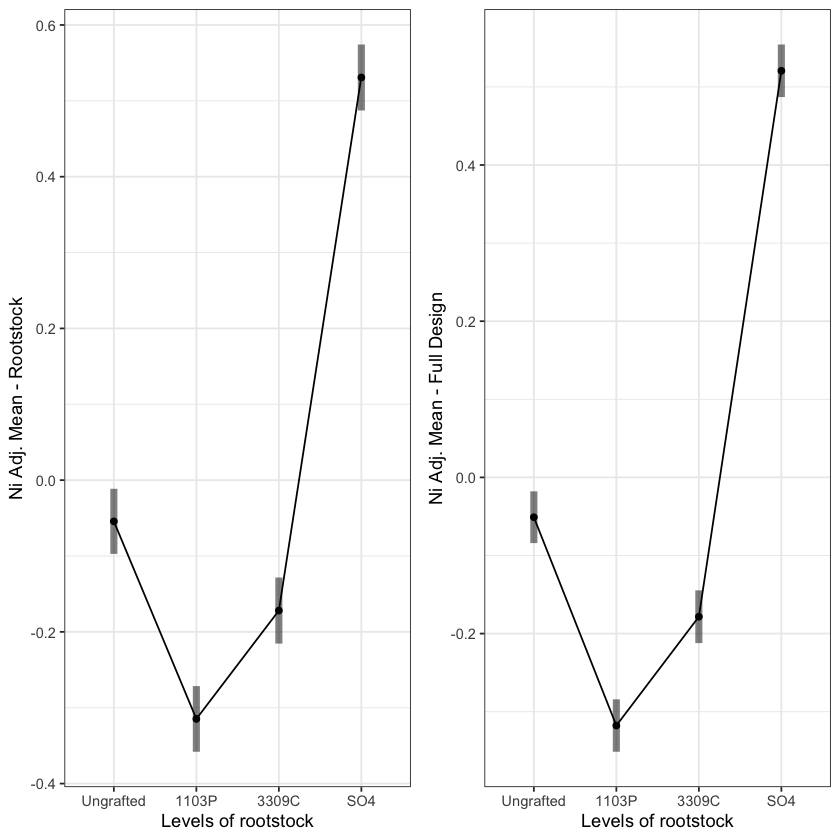

In [9]:
#plots for fun
p1 <- emmeans::emmip(lmod_root, ~rootstock, CIs=T) +  
    ylab("Ni Adj. Mean - Rootstock") + 
    theme_bw()
p2 <- emmeans::emmip(lmod_full, ~rootstock, CIs=T) +  
    ylab("Ni Adj. Mean - Full Design") + 
    theme_bw()

ggpubr::ggarrange(p1, p2, ncol=2, nrow=1, legend='none')

## 3. Does using a repeated measure ANOVA affect results?

Each time we measure these the ionome of these leaves, we return to the same vines year after year. This introduces the oppurtunity for vine-by-vine variation. Using a different model framework (lmer), we can account for that study design. First, I just see how this performs on Nickel, but then I apply it broadly to all ions. AICs suggest the repeated measures model is best for some ions, but not all. However, I want to keep all ions under the same model framework. As such, I use this framework for all ions. 

#### Test base lm against repreated measure and block as random

In [10]:
lmod_base <- lm( Ni ~ block + treatment + year*phenology*rootstock*leafpos, data=d )
lmod_repm <- lmerTest::lmer( Ni ~ block + treatment + year*phenology*rootstock*leafpos + (1 | vine_id), data=d )
lmod_rand <- lmerTest::lmer( Ni ~ treatment + year*phenology*rootstock*leafpos + (1 | vine_id) + (1 | block), data=d )

AIC(lmod_base, lmod_repm, lmod_rand)

,df,AIC
lmod_base,116,16295.23
lmod_repm,117,15981.44
lmod_rand,113,15965.25


In [11]:
performance::r2(lmod_base)
performance::r2(lmod_repm)
performance::r2(lmod_rand)

# R2 for Linear Regression

       R2: 0.474
  adj. R2: 0.466

# R2 for Mixed Models

  Conditional R2: 0.573
     Marginal R2: 0.467

# R2 for Mixed Models

  Conditional R2: 0.572
     Marginal R2: 0.453

#### Test extraction of SS for PVE

In [12]:
#anova modified from lmerTest
most_SS <- anova(lmod_rand, type=3)$Sum
res_SS <- sum(resid(lmod_rand)^2)

data.frame(factor=c(rownames(anova(lmod_rand, type=3)), "residuals"),
           PVE=c(most_SS / sum(most_SS, res_SS) * 100, res_SS / sum(most_SS, res_SS) * 100))

factor,PVE
treatment,0.01212708
year,14.14985618
phenology,11.38073521
rootstock,1.79332902
leafpos,0.79785151
year:phenology,9.04212318
year:rootstock,1.08499807
phenology:rootstock,1.47517956
year:leafpos,0.33719425
phenology:leafpos,3.98930044


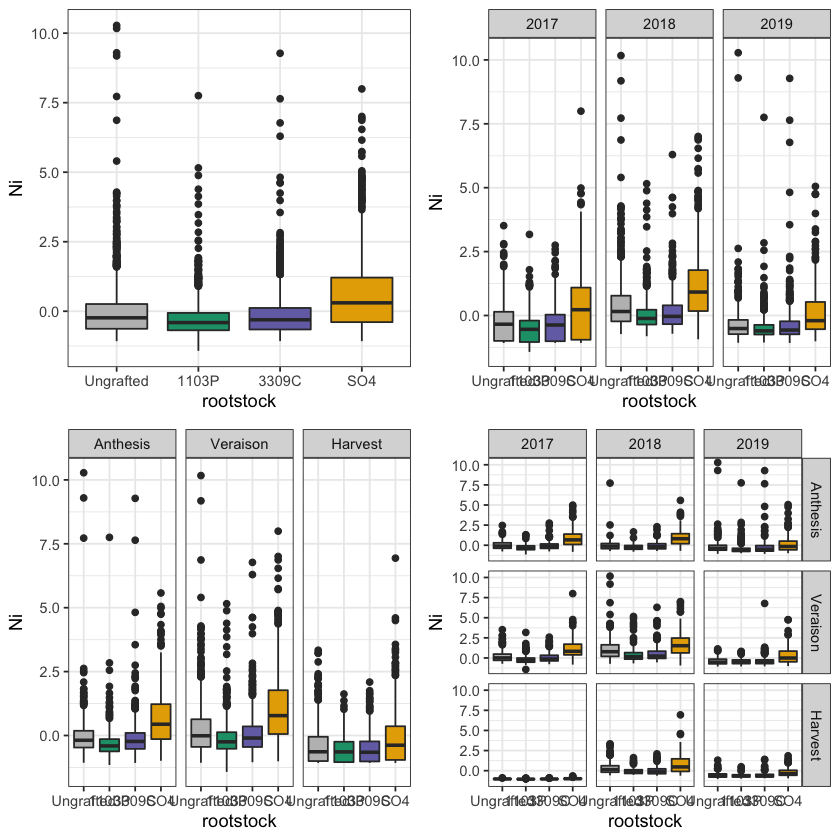

In [13]:
# just looking at those plot when rootstock is involved
p1 <- ggplot(d, aes(x=rootstock, y=Ni, fill=rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual('rootstock', values=rs_palette) + 
  theme_bw()

p2 <- ggplot(d, aes(x=rootstock, y=Ni, fill=rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual('rootstock', values=rs_palette) + 
  facet_wrap('year') + 
  theme_bw()

p3 <- ggplot(d, aes(x=rootstock, y=Ni, fill=rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual('rootstock', values=rs_palette) + 
  facet_wrap('phenology') + 
  theme_bw()

p4 <- ggplot(d, aes(x=rootstock, y=Ni, fill=rootstock)) + 
  geom_boxplot() + 
  scale_fill_manual('rootstock', values=rs_palette) + 
  facet_grid(cols=vars(year), rows=vars(phenology)) + 
  theme_bw()

ggpubr::ggarrange(p1, p2, p3, p4, nrow=2, ncol=2, legend='none')

## 4. Test best model for all ions

Here I explore three different parameterizations. First a model using base lm. Second, the same design using a repeated measure framework. Third, the repeated measure model with block as a random effect. 

I didn't look at changing the optimizers at this point, so there are all sorts of warnings. 

### First, is the z-score transformation most appropriate?

For nickel, it seems that the residuals are not normally distributed. So here, I want to model the z-score transformation, and also try fitting the model to the back-transformed values (concentrations) and log-transformed concentrations. 

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


2019_anthesis_16_B_1_X 2019_anthesis_10_A_3_Y 
                  5596                   5045

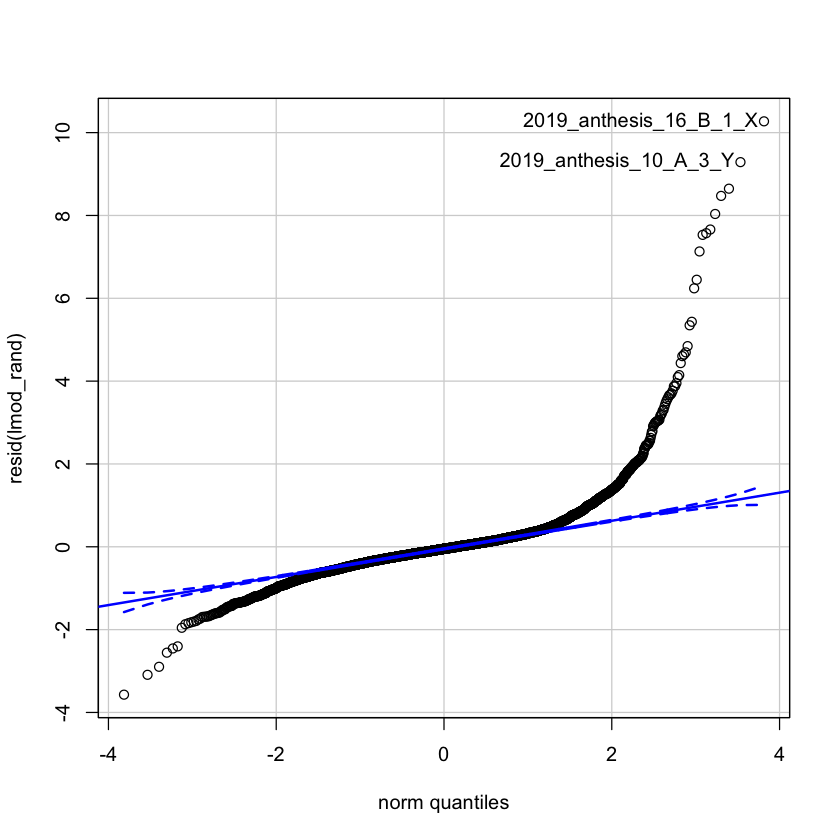

In [14]:
car::qqPlot(resid(lmod_rand))

In [15]:
## read in concentrations and map to meta data
vif_raw <- read.csv('1719_ionomics_BACKTRANSFORMED.csv')
vif_raw$samplename <- vif_raw$X
vif_raw$X <- NULL
vif_raw <- merge(vif_raw, vif_meta, by='samplename')

# Set row number to sample name- for consistency
rownames(vif_raw) <- vif_raw$samplename
vif_raw$row <- as.factor(vif_raw$row)
vif_raw$block <- as.factor(vif_raw$block)
vif_raw$year <- as.factor(vif_raw$year)

# capitalize the Z in leafposition (change to valid data)
vif_raw$leafpos[which(vif_raw$leafpos == 'z')] <- 'Z'

# refactor
vif_raw$leafpos <- factor(vif_raw$leafpos, levels=c('X', 'Y', 'Z'))
vif_raw$rootstock <- factor(vif_raw$rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))
vif_raw$treatment <- factor(vif_raw$treatment, levels=c('None', 'RDI', 'Full'))
vif_raw$phenology <- factor(vif_raw$phenology, levels=c('anthesis','veraison','harvest'), labels=c('Anthesis', 'Veraison', 'Harvest'))
table(vif_raw$leafpos)



   X    Y    Z 
2406 2471 2451 

In [16]:
vif_raw$vine_id <- paste(vif_raw$row, vif_raw$cell, vif_raw$replicate, sep='')
dim(vif_raw)

d_raw <- vif_raw %>% select(Ni, samplename, year:vine_id)
d_raw <- d_raw[d_raw$Ni > 0,]
dim(d_raw)

[1] 7328   32

[1] 7326   12

In [17]:
lmod_rand_zscore <- lmerTest::lmer( Ni ~ treatment + year*phenology*rootstock*leafpos + (1 | vine_id) + (1 | block), data=d )
lmod_rand_concentration <- lmerTest::lmer( Ni ~ treatment + year*phenology*rootstock*leafpos + (1 | vine_id) + (1 | block), data=d_raw )
lmod_rand_logConc <- lmerTest::lmer( log(Ni) ~ treatment + year*phenology*rootstock*leafpos + (1 | vine_id) + (1 | block), data=d_raw )
lmod_rand_sqrtConc <- lmerTest::lmer( sqrt(Ni) ~ treatment + year*phenology*rootstock*leafpos + (1 | vine_id) + (1 | block), data=d_raw )


AIC(lmod_rand_zscore, lmod_rand_concentration, lmod_rand_logConc, lmod_rand_sqrtConc)
performance::r2(lmod_rand_zscore)
performance::r2(lmod_rand_concentration)
performance::r2(lmod_rand_logConc)
performance::r2(lmod_rand_sqrtConc)

Warning message in AIC.default(lmod_rand_zscore, lmod_rand_concentration, lmod_rand_logConc, :
“models are not all fitted to the same number of observations”

,df,AIC
lmod_rand_zscore,113,15965.24894
lmod_rand_concentration,113,14504.53751
lmod_rand_logConc,113,10340.72393
lmod_rand_sqrtConc,113,55.33991


# R2 for Mixed Models

  Conditional R2: 0.572
     Marginal R2: 0.453

# R2 for Mixed Models

  Conditional R2: 0.573
     Marginal R2: 0.453

# R2 for Mixed Models

  Conditional R2: 0.860
     Marginal R2: 0.788

# R2 for Mixed Models

  Conditional R2: 0.735
     Marginal R2: 0.623

In [18]:
x <- performance::r2(lmod_rand_logConc)
x$R2_conditional

Conditional R2 
     0.8599937

2019_anthesis_16_B_1_X 2019_anthesis_10_A_3_Y 
                  5596                   5045

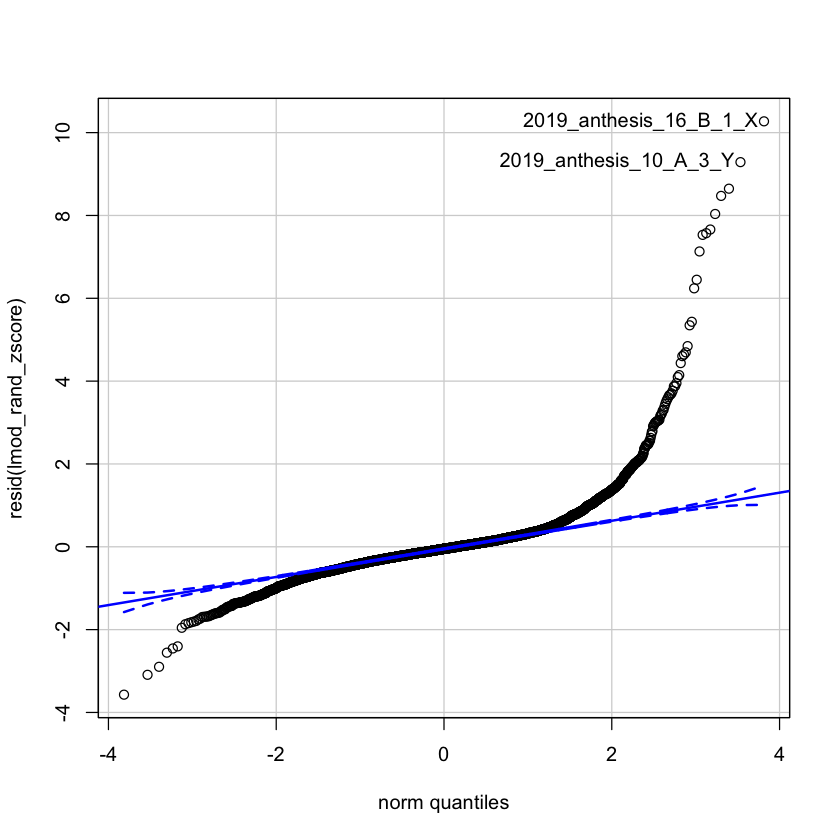

2019_anthesis_16_B_1_X 2019_anthesis_10_A_3_Y 
                  5594                   5043

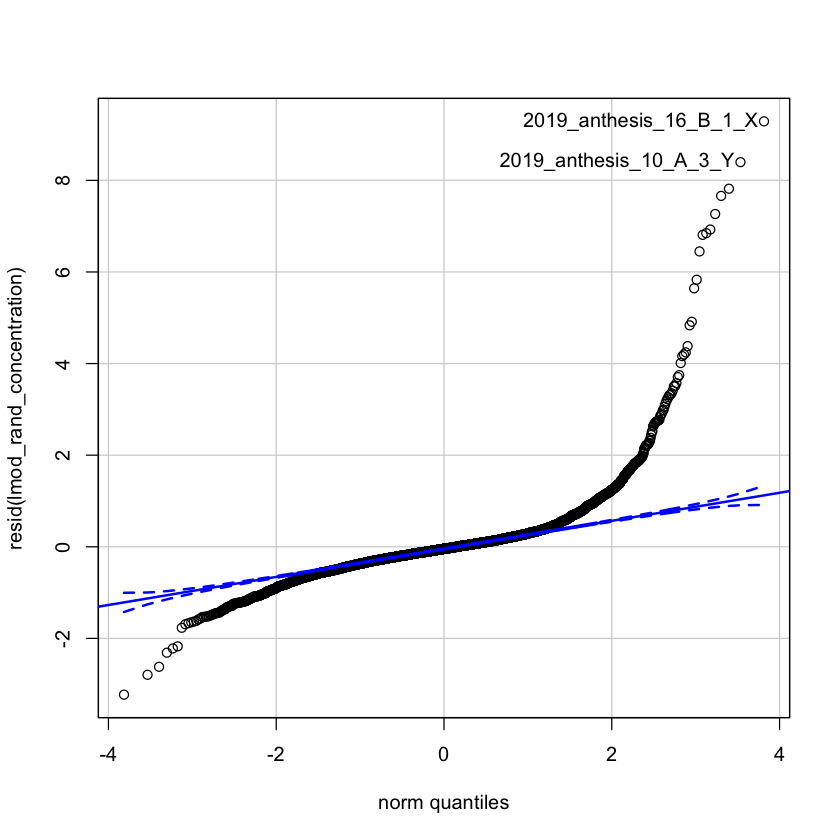

2019_anthesis_11_F_2_X 2019_anthesis_11_A_2_Y 
                  5184                   5130

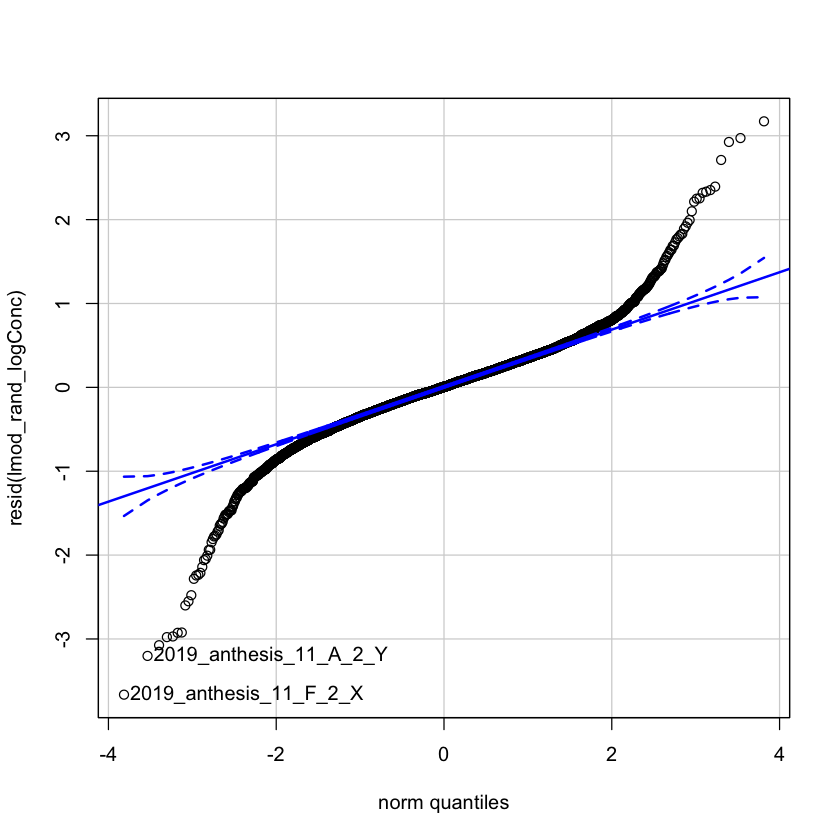

2019_anthesis_16_B_1_X 2019_anthesis_10_A_3_Y 
                  5594                   5043

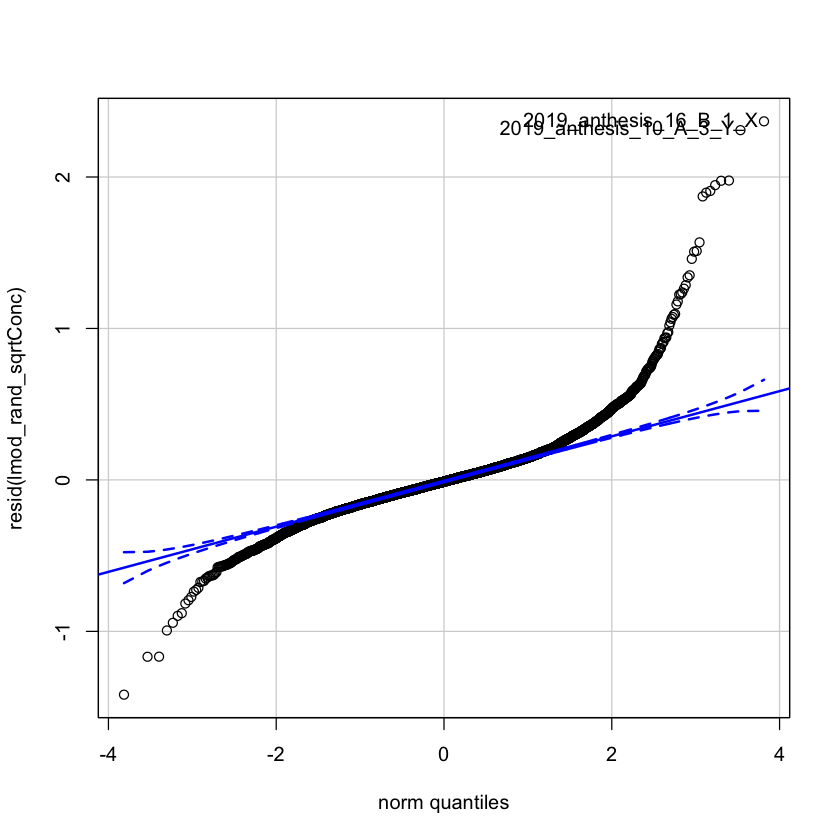

In [19]:
car::qqPlot(resid(lmod_rand_zscore))
car::qqPlot(resid(lmod_rand_concentration))
car::qqPlot(resid(lmod_rand_logConc))
car::qqPlot(resid(lmod_rand_sqrtConc))

In [20]:
stest <- shapiro.test(sample(resid(lmod_rand_sqrtConc), 4999))
log(stest$p.value)

[1] -110.5794

In [21]:
performance::model_performance(lmod_rand_sqrtConc)
e1071::skewness(resid(lmod_rand_sqrtConc))
e1071::kurtosis(resid(lmod_rand_sqrtConc))

AIC,BIC,R2_conditional,R2_marginal,ICC,RMSE,Sigma
55.33991,834.9478,0.7345582,0.6225159,0.2968134,0.2107815,0.216237


[1] 1.743947

[1] 14.544

In [22]:
self_model_performance <- function(lmodel){
    perf <- performance::model_performance(lmodel)
    pval <- log(shapiro.test(sample(resid(lmodel), 4999))$p.value)
    skew <- e1071::skewness(resid(lmodel))
    kurt <- e1071::kurtosis(resid(lmodel))
    return ( c(perf$AIC, perf$BIC, perf$R2_conditional, perf$R2_marginal, perf$RMSE, pval, skew, kurt) )
}

In [23]:
control <- lmerControl(optimizer = "bobyqa")
model_comp <- data.frame(stat=c('AIC', 'BIC', 'R2_conditional', 'R2_marginal', 'RMSE', 'logSWpval', 'skew', 'kurt'))

#for each ion...
for (ion in names(vif)[12:31]){
    d <- select(vif_raw, ion, samplename, year:rootstock, vine_id)
    colnames(d) <- c('element','samplename', 'year', 'phenology', 
                     'row','replicate','cell','leafpos','treatment',
                     'block','rootstock','vine_id')
    d <- d[d$element > 0,]
      
    #raw
    model_conc <- lmerTest::lmer( element ~ treatment + year*phenology*rootstock*leafpos + (1|vine_id) + (1|block), 
                                 data=d, control=control ) 
    model_name <- str_interp("${ion}_raw")
    model_comp[, model_name] <- self_model_performance(model_conc)
    
    # z-score
    model_zconc <- lmerTest::lmer( scale(element) ~ treatment + year*phenology*rootstock*leafpos + (1|vine_id) + (1|block), 
                                 data=d, control=control ) 
    model_name <- str_interp("${ion}_zscore")
    model_comp[, model_name] <- self_model_performance(model_zconc)
    
    #log
    model_logConc <- lmerTest::lmer( log(element) ~ treatment + year*phenology*rootstock*leafpos + (1|vine_id) + (1|block), 
                                    data=d, control=control )
    model_name <- str_interp("${ion}_log")
    model_comp[, model_name] <- self_model_performance(model_logConc)
    
    #sqrt
    model_sqrtConc <- lmerTest::lmer( sqrt(element) ~ treatment + year*phenology*rootstock*leafpos + (1|vine_id) + (1|block), 
                                    data=d, control=control ) 
    model_name <- str_interp("${ion}_sqrt")
    model_comp[, model_name] <- self_model_performance(model_sqrtConc)
    #print(ion)
    
}

rownames(model_comp) <- model_comp$stat 
model_comp$stat <- NULL
model_comp <- as.data.frame(t(model_comp))

boundary (singular) fit: see ?isSingular


Random effect variances not available. Returned R2 does not account for random effects.


boundary (singular) fit: see ?isSingular


Random effect variances not available. Returned R2 does not account for random effects.


boundary (singular) fit: see ?isSingular


Random effect variances not available. Returned R2 does not account for random effects.


boundary (singular) fit: see ?isSingular


Random effect variances not available. Returned R2 does not account for random effects.


boundary (singular) fit: see ?isSingular


Random effect variances not available. Returned R2 does not account for random effects.


boundary (singular) fit: see ?isSingular


Random effect variances not available. Returned R2 does not account for random effects.


boundary (singular) fit: see ?isSingular


Random effect variances not available. Returned R2 does not account for random effects.


boundary (singular) fit: see ?isSingular


Random effect variances not available. Returned R2 does not account for random effects.


In [24]:
dim(model_comp)
model_comp$ion <- rownames(model_comp) %>% str_split(pattern='_') %>% unlist() %>% .[seq(1, length(.), 2)]
model_comp$trans <- rownames(model_comp) %>% str_split(pattern='_') %>% unlist() %>% .[seq(2, length(.), 2)]

[1] 80  8

In [25]:
model_comp[model_comp$kurt > 500,]

,AIC,BIC,R2_conditional,R2_marginal,RMSE,logSWpval,skew,kurt,ion,trans
S_raw,127795.787,128569.766,0.18347792,0.17449484,2455.3250983,-200.7297,19.83710,589.6725,S,raw
S_zscore,19229.909,20003.888,0.18347792,0.17449484,0.8985702,-204.3245,19.83710,589.6725,S,zscore
Se_raw,2444.331,3204.075,0.03942895,0.03612802,0.2697813,-212.5378,36.69403,1704.9219,Se,raw
Se_zscore,17993.946,18753.689,0.03942894,0.03612802,0.9783797,-208.9588,36.69403,1704.9219,Se,zscore


Warning message:
“Removed 8 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 8 rows containing missing values (geom_point).”

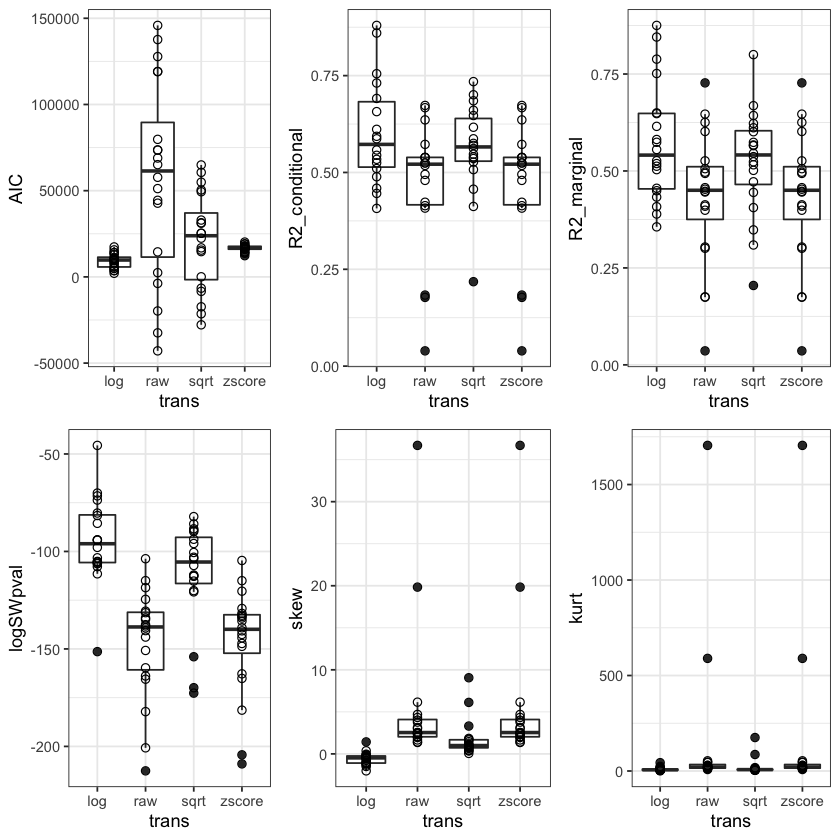

In [26]:
# model_comp$ion <- rownames(model_comp)
# model_comp_long <- model_comp %>% gather(key='model', value='AIC', -ion)
# model_comp_long$model <- factor(model_comp_long$model, 
#                                 levels=c('model_conc', 'model_logConc'))

p1 <- ggplot(model_comp, aes(x=trans, y=AIC)) + 
  geom_boxplot() + 
  geom_point(size=2, shape=21) + 
  theme_bw()

p2 <- ggplot(model_comp, aes(x=trans, y=R2_conditional)) + 
  geom_boxplot() + 
  geom_point(size=2, shape=21) + 
  theme_bw()

p3 <- ggplot(model_comp, aes(x=trans, y=R2_marginal)) + 
  geom_boxplot() + 
  geom_point(size=2, shape=21) + 
  theme_bw()

p4 <- ggplot(model_comp, aes(x=trans, y=logSWpval)) + 
  geom_boxplot() + 
  geom_point(size=2, shape=21) + 
  theme_bw()

p5 <- ggplot(model_comp, aes(x=trans, y=skew)) + 
  geom_boxplot() + 
  geom_point(size=2, shape=21) + 
  theme_bw()

p6 <- ggplot(model_comp, aes(x=trans, y=kurt)) + 
  geom_boxplot() + 
  geom_point(size=2, shape=21) + 
  theme_bw()

ggpubr::ggarrange(p1, p2, p3, p4, p5, p6, ncol=3, nrow=2)

Full models are clearly the best. Since the design is a repeated measure, we are going with the repeated measure framework. There doesnt seem to be much difference between treating block as a random or fixed effect, so I am going to keep it random for now. 

## 5. Fit the new models

Here, I fit the new models and then make two versions of the heatmap figure. The first is the full version with all factors in the model. The Second extracts the rootstock related terms and plots them alone. This re-adjusts the color scale to focus on the rootstock story. 

In [27]:
datasets <- list()
models <- list()
anovas <- list()
means <- list()
sds <- list()
control <- lmerControl(optimizer = "bobyqa")

for (ion in names(vif)[12:31]){
    print(ion)
    d <- select(vif_raw, ion, samplename, year:rootstock)
    d$vine_id <- paste(d$row, d$cell, d$replicate, sep='')
    colnames(d) <- c('element','samplename', 'year', 'phenology', 
                     'row','replicate','cell','leafpos','treatment',
                     'block','rootstock','vine_id')
    
    d <- d[d$element > 0,]
    means[[ion]] <- mean(log(d$element))
    sds[[ion]] <- sd(log(d$element))
    d$element <- scale(log(d$element))
    datasets[[ion]] <- d


    # fit lme4 model
    lmod_full_rep <- lmerTest::lmer( element ~ treatment + year*phenology*rootstock*leafpos + (1|vine_id) + (1|block), 
                                    data=d, control=control )
    models[[ion]] <- lmod_full_rep
    
    #store type 3 anova
    ion_anova <- anova(lmod_full_rep, type=3)
    anovas[[ion]] <- list(anova=ion_anova, rss=sum(resid(lmod_full_rep)^2))
}

[1] "B"
[1] "Na"
[1] "Mg"
[1] "Al"
[1] "P"


boundary (singular) fit: see ?isSingular


[1] "S"
[1] "K"
[1] "Ca"
[1] "Fe"
[1] "Mn"
[1] "Co"
[1] "Ni"
[1] "Cu"
[1] "Zn"


boundary (singular) fit: see ?isSingular


[1] "As"
[1] "Se"
[1] "Rb"
[1] "Sr"
[1] "Mo"
[1] "Cd"


In [28]:
for (ion in names(vif)[12:31]){
    print(c(ion, isSingular(models[[ion]])))
}

[1] "B"     "FALSE"
[1] "Na"    "FALSE"
[1] "Mg"    "FALSE"
[1] "Al"    "FALSE"
[1] "P"    "TRUE"
[1] "S"     "FALSE"
[1] "K"     "FALSE"
[1] "Ca"    "FALSE"
[1] "Fe"    "FALSE"
[1] "Mn"    "FALSE"
[1] "Co"    "FALSE"
[1] "Ni"    "FALSE"
[1] "Cu"    "FALSE"
[1] "Zn"   "TRUE"
[1] "As"    "FALSE"
[1] "Se"    "FALSE"
[1] "Rb"    "FALSE"
[1] "Sr"    "FALSE"
[1] "Mo"    "FALSE"
[1] "Cd"    "FALSE"


In [29]:
calc_PVE <- function(x){
    SS <- c(x$anova$Sum, x$rss)
    output <- SS / sum(SS)
    return (output)
}

PVE <- as.data.frame(lapply(X=anovas, FUN=calc_PVE))
rownames(PVE) <- c(rownames(anovas[['B']]$anova), 'Residuals')

PVE
#sanity check
colSums(PVE)
#pull out highest
rev(sort(PVE['rootstock', ]))
rev(sort(PVE['year:rootstock', ]))
rev(sort(PVE['phenology:rootstock', ]))
rev(sort(PVE['rootstock:leafpos', ]))
rev(sort(PVE['year:phenology:rootstock', ]))

write.csv(PVE, 'final_run/1719_ionomics_PVEspread.csv', quote=F)

,B,Na,Mg,Al,P,S,K,Ca,Fe,Mn,Co,Ni,Cu,Zn,As,Se,Rb,Sr,Mo,Cd
treatment,0.0008481373,0.0002232452,0.0002080609,0.0003246190,0.0002700776,0.0001462777,0.0005238132,7.673574e-05,3.618038e-06,0.0003079873,0.0007911499,0.0001077711,0.0001698550,2.902456e-05,0.0014262352,0.0041823287,1.679359e-06,0.0003729611,0.001221602,0.0003208486
year,0.0421210369,0.0438918162,0.0873663906,0.1732813477,0.2623959704,0.1700101729,0.1768990554,6.579922e-02,2.194885e-01,0.0656938835,0.1344085056,0.2061853578,0.0563188065,1.054390e-01,0.0054431852,0.1186095201,7.516814e-02,0.0962625387,0.029752743,0.4362298011
phenology,0.2150404248,0.0426284384,0.1216657324,0.0832913814,0.3408737433,0.2192713363,0.0508803242,6.036713e-02,1.417356e-02,0.0979144827,0.1775906232,0.2374718512,0.1943460018,9.990861e-02,0.0788421279,0.0651691685,1.114317e-01,0.1438233188,0.159200290,0.1202601397
rootstock,0.0114978467,0.0016530836,0.0257071040,0.0003422653,0.0057612022,0.0030388308,0.0083606664,7.771887e-03,1.152011e-02,0.0037716871,0.0046930145,0.0047391160,0.0078032949,3.693194e-04,0.0087054613,0.0009183340,6.352424e-03,0.0149777113,0.014552520,0.0050376371
leafpos,0.0759804939,0.2538253579,0.0237089808,0.0863620937,0.0493029096,0.0202042473,0.1654760076,1.482008e-01,1.013595e-01,0.3076332298,0.1187386116,0.0071700744,0.2209194733,1.079404e-01,0.1580207944,0.0030626471,3.185029e-01,0.0833745201,0.014337938,0.0136794423
year:phenology,0.1423383019,0.0656498296,0.1354667633,0.1600528286,0.1636991247,0.4580737783,0.0597061960,1.734418e-01,5.220434e-02,0.0273791827,0.1794833128,0.3542051571,0.0206742064,3.518448e-02,0.1682098634,0.1151043545,1.985451e-02,0.2428027233,0.072558683,0.1552904840
year:rootstock,0.0018022232,0.0016817377,0.0020585675,0.0016064531,0.0005997260,0.0011660069,0.0013765148,4.402262e-04,2.696086e-03,0.0009567981,0.0031323675,0.0022417735,0.0016226966,1.412872e-04,0.0047798500,0.0088451758,1.168026e-03,0.0009707965,0.011695663,0.0003215337
phenology:rootstock,0.0051258698,0.0025267282,0.0036259857,0.0006194070,0.0012279817,0.0011819629,0.0020232163,2.575059e-03,6.823866e-04,0.0055763688,0.0181342202,0.0004334992,0.0020086524,6.752664e-04,0.0004995836,0.0003181517,2.015356e-03,0.0047498146,0.010552944,0.0005889313
year:leafpos,0.0043366068,0.0023263715,0.0050887344,0.0055717784,0.0006596687,0.0087574120,0.0034322181,2.909898e-03,1.123334e-02,0.0319239444,0.0025727367,0.0016043593,0.0070923135,2.454911e-02,0.0189092619,0.0513233386,1.086815e-03,0.0025985774,0.011698573,0.0106229183
phenology:leafpos,0.0081874375,0.0264511920,0.0262546007,0.0660415464,0.0092348963,0.0011656380,0.0506779384,4.011988e-02,8.585968e-03,0.0281517074,0.0335714372,0.0217044827,0.0487478935,2.352999e-02,0.0531267127,0.0178996854,1.260196e-01,0.0272944218,0.024827699,0.0031571345


B Na Mg Al  P  S  K Ca Fe Mn Co Ni Cu Zn As Se Rb Sr Mo Cd 
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

,Mg,Sr,Mo,Fe,B,As,K,Cu,Ca,Rb,P,Cd,Ni,Co,Mn,S,Na,Se,Zn,Al
rootstock,0.0257071,0.01497771,0.01455252,0.01152011,0.01149785,0.008705461,0.008360666,0.007803295,0.007771887,0.006352424,0.005761202,0.005037637,0.004739116,0.004693014,0.003771687,0.003038831,0.001653084,0.000918334,0.0003693194,0.0003422653


,Mo,Se,As,Co,Fe,Ni,Mg,B,Na,Cu,Al,K,Rb,S,Sr,Mn,P,Ca,Cd,Zn
year:rootstock,0.01169566,0.008845176,0.00477985,0.003132368,0.002696086,0.002241773,0.002058568,0.001802223,0.001681738,0.001622697,0.001606453,0.001376515,0.001168026,0.001166007,0.0009707965,0.0009567981,0.000599726,0.0004402262,0.0003215337,0.0001412872


,Co,Mo,Mn,B,Sr,Mg,Ca,Na,K,Rb,Cu,P,S,Fe,Zn,Al,Cd,As,Ni,Se
phenology:rootstock,0.01813422,0.01055294,0.005576369,0.00512587,0.004749815,0.003625986,0.002575059,0.002526728,0.002023216,0.002015356,0.002008652,0.001227982,0.001181963,0.0006823866,0.0006752664,0.000619407,0.0005889313,0.0004995836,0.0004334992,0.0003181517


,Mg,P,As,K,Co,Ca,Fe,Mn,S,Mo,Zn,Na,Se,Sr,Cd,Al,Ni,Cu,B,Rb
rootstock:leafpos,0.00960817,0.005050452,0.00397728,0.00335015,0.002492391,0.00236592,0.002112635,0.002076972,0.001654071,0.001573859,0.001018933,0.001017482,0.0009527631,0.0007862182,0.0007344628,0.0007321177,0.0006444419,0.0005666587,0.0004995367,0.0002453869


,Mo,Cu,Fe,Co,B,Ni,Se,As,Ca,Na,Mn,Mg,Rb,K,Cd,Al,Sr,Zn,P,S
year:phenology:rootstock,0.006744137,0.00449534,0.003781228,0.00367307,0.002976364,0.002805911,0.002612311,0.002432239,0.002105103,0.00197325,0.001661893,0.001609473,0.001523113,0.001479427,0.001404417,0.001379419,0.001361338,0.001241049,0.0008577436,0.0004233897


In [30]:
PVE_plot <- as.data.frame(t(PVE))
PVE_plot$Residuals <- NULL
PVE_plot$ion <- rownames(PVE_plot)
PVE_plot <- PVE_plot %>% gather(key='factor', value='PVE', -ion)

for (ion in names(anovas)){
    if (ion == 'B'){
        p_mat <- data.frame(ion=rep(ion, 16),
                            factor=rownames(anovas[[ion]][['anova']]),
                            p.val = anovas[[ion]]$anova$Pr)
    } else {
        p_mat.tmp <- data.frame(ion=rep(ion, 16),
                                factor=rownames(anovas[[ion]][['anova']]),
                                p.val = anovas[[ion]]$anova$Pr)
        p_mat <- rbind(p_mat ,p_mat.tmp)
    }
}

p_mat$p.adj <- p.adjust(p_mat$p.val, method='fdr')
PVE_plot <- merge(PVE_plot, p_mat, by=c('ion', 'factor'))
PVE_plot$PVE[PVE_plot$p.adj > 0.05] <- NA

PVE_plot$factor <- factor(PVE_plot$factor, levels=c(#'block', 
                                                    'treatment', 'year', 'phenology', 'rootstock', 'leafpos',
                                                    'year:phenology', 'year:rootstock', 'year:leafpos', 
                                                    'phenology:rootstock', 'phenology:leafpos', 'rootstock:leafpos',
                                                    'year:phenology:rootstock', 'year:phenology:leafpos',
                                                    'year:rootstock:leafpos','phenology:rootstock:leafpos',
                                                    'year:phenology:rootstock:leafpos'),
                          labels=c(#'B', 
                                   'I', 'Y', 'P', 'R', 'L', 'YP', 'YR', 'YL', 
                                   'PR', 'PL', 'RL', 'YPR', 'YPL', 'YRL', 'PRL', 'YPRL'))

PVE_plot$ion <- as.factor(PVE_plot$ion)
PVE_plot$ion <- factor(PVE_plot$ion, levels=rev(levels(PVE_plot$ion)))
head(PVE_plot)

write.csv(PVE_plot, file='final_run/1719_ionomics_lmerPVE.csv', quote=F)

ion,factor,PVE,p.val,p.adj
Al,L,0.08636209,1.467223e-296,1.043358e-295
Al,P,0.08329138,4.594016e-287,3.195837e-286
Al,PL,0.06604155,2.698699e-229,1.542114e-228
Al,PR,NA,9.508028e-02,1.174737e-01
Al,PRL,NA,4.455849e-01,4.817135e-01
Al,R,NA,1.159469e-01,1.421571e-01


In [31]:
#whole plot
pdf('final_run/ionomics_variance_heatmap_lme4Model_logConcScaled.pdf', height=9, width=16)
ggplot(PVE_plot, aes(x=factor, y=ion, fill=PVE*100)) + 
  geom_tile(color='white', size=0.5) + 
  scale_fill_viridis_c(option='inferno', direction=-1, na.value = "transparent") + 
  labs(x = "Factor", y="") +
  scale_x_discrete(position='top') +
  #ggpubr::theme_classic2() + 
  theme_minimal() + 
  theme(axis.text=element_text(size=14), 
        axis.title=element_text(size=12, face="bold"),
        legend.position = "bottom")

dev.off()

pdf 
  2

In [34]:
PVE_plot2 <- PVE_plot
PVE_plot2$factor <- factor(PVE_plot2$factor, 
                          levels=c('R', 'Y', 'P', 'L',
                                   'YP', 'YL', 'PL', 'YR',
                                   'PR', 'RL', 'YPL', 'YPR',
                                   'YRL', 'PRL', 'YPRL', 'I'),
                          labels=c('R', 'Y', 'P', 'L',
                                   'YP', 'YL', 'PL', 'YR',
                                   'PR', 'LR', 'YPL', 'YPR',
                                   'YLR', 'PLR', 'YPLR', 'I'))

#whole plot reordered to follow MS order
pdf('final_run/ionomics_variance_heatmap_lme4Model_logConcScaled_reorder.pdf', height=9, width=16)
ggplot(PVE_plot2, aes(x=factor, y=ion, fill=PVE*100)) + 
  geom_tile(color='white', size=0.5) + 
  scale_fill_viridis_c(option='inferno', direction=-1, na.value = "transparent") + 
  labs(x = "Factor", y="") +
  scale_x_discrete(position='top') +
  #ggpubr::theme_classic2() + 
  theme_minimal() + 
  theme(axis.text=element_text(size=14), 
        axis.title=element_text(size=12, face="bold"),
        legend.position = "bottom")

dev.off()

pdf 
  2

In [32]:
#just JEP Terms
PVE_plot_JEP <- PVE_plot[PVE_plot$factor %in% c('Y', 'P', 'L', 'PL'),]
sumPVE <- PVE_plot_JEP %>% na.omit() %>% group_by(ion)# %>% summarise(PVE=sum(PVE))
head(sumPVE)

png('final_run/ionomics_variance_heatmap_lme4Model_JEP_logConc.png', height=8, width=6, units='in', res=1200)
ggplot(PVE_plot_JEP, aes(x=factor, y=ion, fill=PVE*100)) + 
  geom_tile(color='white', size=0.5) + 
  scale_fill_viridis_c(option='inferno', direction=-1, na.value = "transparent") + 
  labs(x = "Factor", y="") +
  scale_x_discrete(position='top') +
  theme_minimal() + 
  theme(axis.text=element_text(size=14), 
        axis.title=element_text(size=12, face="bold"),
        legend.position = "bottom")

dev.off()

ion,factor,PVE,p.val,p.adj
Al,L,0.08636209,1.467223e-296,1.043358e-295
Al,P,0.08329138,4.594016e-287,3.195837e-286
Al,PL,0.06604155,2.698699e-229,1.542114e-228
Al,Y,0.17328135,0.000000e+00,0.000000e+00
As,L,0.15802079,0.000000e+00,0.000000e+00
As,P,0.07884213,5.148155e-234,3.050758e-233


pdf 
  2

In [15]:
#just rs + interactions * SUM column
PVE_plot_rs <- PVE_plot[PVE_plot$factor %in% c('R', 'YR', 'PR', 'RL', 'YPR', 'YRL', 'PRL', 'YPRL'),]
sumPVE <- PVE_plot_rs %>% na.omit() %>% group_by(ion) %>% summarise(PVE=sum(PVE))
sumPVE$factor <- rep("Sum", nrow(sumPVE))
sumPVE$p.val <- rep(0, nrow(sumPVE))
sumPVE$p.adj <- rep(0, nrow(sumPVE))
#ensure order for safety
sumPVE <- sumPVE %>% select(ion, factor, PVE, p.val, p.adj)

PVE_plot_rs <- rbind(PVE_plot_rs, sumPVE)
levels(PVE_plot_rs$factor)

[1] "I"    "Y"    "P"    "R"    "L"    "YP"   "YR"   "YL"   "PR"   "PL"  
[11] "RL"   "YPR"  "YPL"  "YRL"  "PRL"  "YPRL" "Sum"

In [17]:
pdf('ionomics_variance_heatmap_lme4Model_rs_logConc.pdf', height=9, width=16)
ggplot(PVE_plot_rs, aes(x=factor, y=ion, fill=PVE*100)) + 
  geom_tile(color='white', size=0.5) + 
  scale_fill_viridis_c(option='inferno', direction=-1, na.value = "transparent") + 
  labs(x = "Factor", y="") +
  scale_x_discrete(position='top') +
  #ggpubr::theme_classic2() + 
  theme_minimal() + 
  theme(axis.text=element_text(size=14), 
        axis.title=element_text(size=12, face="bold"),
        legend.position = "bottom")

dev.off()

pdf 
  2

## 6. Adjusted Means Plots for Time Components

Here I just go factor by factor and make plots with adjusted means and standard errors. I also print to each figure labels for significance regardless of the actual post-hocs. These will be arduously edited in inkscape. 

Could this be wrapped in more efficient functions? Yes

In [37]:
emmeans::emm_options(pbkrtest.limit = 3000, lmerTest.limit = 3000)

### Year

In [45]:
ions <- levels(PVE_plot$ion)

main_plots <- list()
for (i in ions){
    i.df <- emmeans::emmip(models[[i]], ~year, CIs=T, plotit=F, data=datasets[[i]])
    i.df$yvar <- exp(i.df$yvar * sds[[i]] + means[[i]])
    i.df$LCL <- exp(i.df$LCL * sds[[i]] + means[[i]])
    i.df$UCL <- exp(i.df$UCL * sds[[i]] + means[[i]])
    p <- ggplot(i.df, aes(x=year, y=yvar, ymin=LCL, ymax=UCL, color=year, fill=year)) + 
      geom_linerange(lwd=2) + 
      scale_color_manual("Year", values=y_palette) + 
      geom_point(size=7, shape=21, color='black') + 
      scale_fill_manual("Year", values=y_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      geom_text(aes(x = year, y = max(UCL)*1.1, label=c('a', 'a', 'a')), size = 6, color='black') + 
      theme_bw()
    main_plots[[i]] <- p
}

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

In [46]:
pdf("final_run/1719_ionomics_year_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']], main_plots[['Sr']], main_plots[['Zn']],
                  nrow=4, ncol=5, legend=F)
dev.off()

pdf 
  2

### Phenology

In [49]:
ions <- levels(PVE_plot$ion)

main_plots <- list()
for (i in ions){
    i.df <- emmeans::emmip(models[[i]], ~phenology, CIs=T, plotit=F, data=datasets[[i]])
    i.df$yvar <- exp(i.df$yvar * sds[[i]] + means[[i]])
    i.df$LCL <- exp(i.df$LCL * sds[[i]] + means[[i]])
    i.df$UCL <- exp(i.df$UCL * sds[[i]] + means[[i]])
    p <- ggplot(i.df, aes(x=phenology, y=yvar, ymin=LCL, ymax=UCL, color=phenology, fill=phenology)) + 
      geom_linerange(lwd=2) + 
      scale_color_manual("Phenology", values=p_palette) + 
      geom_point(size=7, shape=21, color='black') + 
      scale_fill_manual("Phenology", values=p_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      geom_text(aes(x = phenology, y = max(UCL)*1.1, label=c('a', 'a', 'a')), size = 6, color='black') + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("final_run/1719_ionomics_phenology_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']], main_plots[['Sr']], main_plots[['Zn']],
                  nrow=4, ncol=5, legend=F)
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

### Leafpos

In [144]:
main_plots <- list()
for (i in ions){
    i.df <- emmeans::emmip(models[[i]], ~leafpos, CIs=T, plotit=F, data=datasets[[i]])
    i.df$yvar <- exp(i.df$yvar * sds[[i]] + means[[i]])
    i.df$LCL <- exp(i.df$LCL * sds[[i]] + means[[i]])
    i.df$UCL <- exp(i.df$UCL * sds[[i]] + means[[i]])
    p <- ggplot(i.df, aes(x=leafpos, y=yvar, ymin=LCL, ymax=UCL, color=leafpos, fill=leafpos)) + 
      geom_linerange(lwd=2) + 
      scale_color_manual("Leaf position", values=l_palette) + 
      geom_point(size=7, shape=21, color='black') + 
      scale_fill_manual("Leaf position", values=l_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      xlab("Leaf position") + 
      scale_x_discrete(labels=c('Y', 'M', 'O')) + 
      geom_text(aes(x = leafpos, y = max(UCL)*1.1, label=c('a', 'a', 'a')), size = 6, color='black') + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("final_run/1719_ionomics_leafpos_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']],main_plots[['Sr']], main_plots[['Zn']],
                  nrow=4, ncol=5, legend=F)
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

### Year by Phenology

In [52]:
pd <- position_dodge(0.3)

get_emmip_values <- function(fit_models, ion, f1, f2, dataset){
    int.df <- emmeans::emmip(fit_models[[ion]], as.formula(str_interp("~${f1}|${f2}")), CIs=T, plotit=F, data=dataset)
    int.df$yvar <- exp(int.df$yvar * sds[[ion]] + means[[ion]])
    int.df$LCL <- exp(int.df$LCL * sds[[ion]] + means[[ion]])
    int.df$UCL <- exp(int.df$UCL * sds[[ion]] + means[[ion]])
    int.df$ion <- rep(ion, nrow(int.df))
    return (int.df)
}

In [154]:
ions <- levels(PVE_plot$ion)
main_plots <- list()

for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'phenology', 'year', dataset=datasets[[i]])
    p <- ggplot(p.df, aes(x=year, y=yvar, ymin=LCL, ymax=UCL, group=phenology)) + 
      geom_line(aes(color=phenology), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Phenology', values=p_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("final_run/1719_ionomics_phenologyYear_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']],main_plots[['Sr']], main_plots[['Zn']],
                  nrow=4, ncol=5, common.legend=T)
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

In [153]:
main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'year', 'phenology', data=datasets[[i]])
    p <- ggplot(p.df, aes(x=phenology, y=yvar, ymin=LCL, ymax=UCL, group=year)) + 
      geom_line(aes(color=year), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Year', values=y_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("final_run/1719_ionomics_yearPhenology_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']],main_plots[['Sr']], main_plots[['Zn']],
                  nrow=4, ncol=5, common.legend=T)
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

### Year by Leafpos

In [161]:
ions <- levels(PVE_plot$ion)

main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'leafpos', 'year', data=datasets[[i]])
    p <- ggplot(p.df, aes(x=year, y=yvar, ymin=LCL, ymax=UCL, group=leafpos)) + 
      geom_line(aes(color=leafpos), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Leafpos', values=l_palette) + 
      scale_x_discrete(labels=c('Y', 'M', 'O')) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("final_run/1719_ionomics_leafposYear_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']], main_plots[['Sr']], main_plots[['Zn']],
                  nrow=4, ncol=5, common.legend=T)
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

In [162]:
main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'year', 'leafpos', data=datasets[[i]])
    p <- ggplot(p.df, aes(x=leafpos, y=yvar, ymin=LCL, ymax=UCL, group=year)) + 
      geom_line(aes(color=year), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Year', values=y_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("final_run/1719_ionomics_yearLeafpos_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']], main_plots[['Sr']], main_plots[['Zn']],
                  nrow=4, ncol=5, common.legend=T)
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

### Phenology by Leafpos

In [158]:
main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'leafpos', 'phenology', data=datasets[[i]])
    p <- ggplot(p.df, aes(x=phenology, y=yvar, ymin=LCL, ymax=UCL, group=leafpos)) + 
      geom_line(aes(color=leafpos), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Leafpos', values=l_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("final_run/1719_ionomics_leafposPhenology_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']],main_plots[['Sr']], main_plots[['Zn']],
                  nrow=4, ncol=5, common.legend=T)
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

In [159]:
main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'phenology', 'leafpos', data=datasets[[i]])
    p <- ggplot(p.df, aes(x=leafpos, y=yvar, ymin=LCL, ymax=UCL, group=phenology)) + 
      geom_line(aes(color=phenology), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Phenology', values=p_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      scale_x_discrete(labels=c('Y', 'M', 'O')) + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("final_run/1719_ionomics_phenologyLeafpos_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']],main_plots[['Sr']], main_plots[['Zn']],
                  nrow=4, ncol=5, common.legend=T)
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

In [75]:
0.05/20

[1] 0.0025

In [187]:
pairs(emmeans::emmeans(models[['Sr']], ~rootstock))

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


 contrast          estimate     SE  df z.ratio p.value
 Ungrafted - 1103P -0.00811 0.0363 Inf  -0.223 0.9961 
 Ungrafted - 3309C  0.44027 0.0363 Inf  12.115 <.0001 
 Ungrafted - SO4   -0.13851 0.0363 Inf  -3.815 0.0008 
 1103P - 3309C      0.44838 0.0364 Inf  12.314 <.0001 
 1103P - SO4       -0.13040 0.0364 Inf  -3.585 0.0019 
 3309C - SO4       -0.57878 0.0364 Inf -15.886 <.0001 

Results are averaged over the levels of: treatment, year, phenology, leafpos 
Degrees-of-freedom method: asymptotic 
P value adjustment: tukey method for comparing a family of 4 estimates 

## 7. Adjusted Means Plots for Rootstock Terms

In [184]:
ions <- levels(PVE_plot$ion)

main_plots <- list()
for (i in ions){
    i.df <- emmeans::emmip(models[[i]], ~rootstock, CIs=T, plotit=F, data=datasets[[i]])
    i.df$yvar <- exp(i.df$yvar * sds[[i]] + means[[i]])
    i.df$LCL <- exp(i.df$LCL * sds[[i]] + means[[i]])
    i.df$UCL <- exp(i.df$UCL * sds[[i]] + means[[i]])
    p <- ggplot(i.df, aes(x=rootstock, y=yvar, ymin=LCL, ymax=UCL, color=rootstock, fill=rootstock)) + 
      geom_linerange(lwd=2) + 
      scale_color_manual("Rootstock", values=rs_palette) + 
      geom_point(size=7, shape=21, color='black') + 
      scale_fill_manual("Rootstock", values=rs_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      geom_text(aes(x = rootstock, y = max(UCL)*1.05, label=c('a', 'a', 'a', 'a')), size = 6, color='black') + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("final_run/1719_ionomics_rootstock_logConc.pdf", height=16, width=20)
ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], 
                  main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
                  main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
                  main_plots[['Rb']], main_plots[['S']], main_plots[['Se']],main_plots[['Sr']], main_plots[['Zn']],
                 nrow=4, ncol=5, legend=F)
dev.off()

pdf("final_run/Figure_2.pdf", height=8, width=8)
ggpubr::ggarrange(main_plots[['Mg']], main_plots[['Sr']], main_plots[['Mo']], main_plots[['Ni']], 
                 nrow=2, ncol=2, legend=F, labels=c('A', 'B', 'C', 'D'))
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

pdf 
  2

### Year by Rootstock

In [56]:
## this was done after to get numbers for the ms

i='Mo'
pairs(emmeans::emmeans(models[[i]], ~rootstock|year, data=datasets[[i]]), )

i='Se'
pairs(emmeans::emmeans(models[[i]], ~rootstock|year, data=datasets[[i]]))

NOTE: Results may be misleading due to involvement in interactions


year = 2017:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P   -0.684 0.0765 407  -8.939 <.0001 
 Ungrafted - 3309C   -0.206 0.0766 408  -2.696 0.0366 
 Ungrafted - SO4     -0.916 0.0766 409 -11.952 <.0001 
 1103P - 3309C        0.478 0.0765 407   6.239 <.0001 
 1103P - SO4         -0.232 0.0766 408  -3.024 0.0140 
 3309C - SO4         -0.709 0.0766 409  -9.254 <.0001 

year = 2018:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P   -0.606 0.0767 411  -7.902 <.0001 
 Ungrafted - 3309C   -0.183 0.0768 412  -2.387 0.0811 
 Ungrafted - SO4     -0.893 0.0768 413 -11.629 <.0001 
 1103P - 3309C        0.423 0.0768 412   5.511 <.0001 
 1103P - SO4         -0.287 0.0768 412  -3.735 0.0012 
 3309C - SO4         -0.710 0.0768 413  -9.239 <.0001 

year = 2019:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P   -0.150 0.0776 430  -1.936 0.2147 
 Ungrafted - 3309C    0.237 0.0779 435   3.043 0.0132 
 Ungrafted - SO4     -0.

NOTE: Results may be misleading due to involvement in interactions


year = 2017:
 contrast           estimate     SE   df t.ratio p.value
 Ungrafted - 1103P  0.236515 0.0571 1696  4.139  0.0002 
 Ungrafted - 3309C -0.099139 0.0527 1327 -1.881  0.2366 
 Ungrafted - SO4    0.278913 0.0601 1965  4.638  <.0001 
 1103P - 3309C     -0.335654 0.0566 1666 -5.926  <.0001 
 1103P - SO4        0.042398 0.0636 2292  0.666  0.9097 
 3309C - SO4        0.378052 0.0597 1938  6.336  <.0001 

year = 2018:
 contrast           estimate     SE   df t.ratio p.value
 Ungrafted - 1103P -0.168078 0.0508 1188 -3.308  0.0054 
 Ungrafted - 3309C -0.083808 0.0511 1201 -1.641  0.3559 
 Ungrafted - SO4   -0.236986 0.0505 1165 -4.693  <.0001 
 1103P - 3309C      0.084270 0.0514 1220  1.641  0.3559 
 1103P - SO4       -0.068909 0.0508 1184 -1.357  0.5269 
 3309C - SO4       -0.153178 0.0510 1198 -3.001  0.0146 

year = 2019:
 contrast           estimate     SE   df t.ratio p.value
 Ungrafted - 1103P  0.077532 0.0539 1418  1.439  0.4752 
 Ungrafted - 3309C  0.010629 0.0542 1415  0.196

In [20]:
ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Ca', 'Cd', 'Zn')])

main_plots <- list()
for (i in ions){
    p.df <- get_emmip_values(models, i, 'year', 'rootstock', dataset=datasets[[i]])
    p <- ggplot(p.df, aes(x=rootstock, y=yvar, ymin=LCL, ymax=UCL, group=year)) + 
      geom_line(aes(color=year), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Year', values=y_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

# pdf("1719_ionomics_yearRootstock_logConc.pdf", height=16, width=20)
# ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], 
#                   main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
#                   main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
#                   main_plots[['Rb']], main_plots[['S']], main_plots[['Se']],main_plots[['Sr']],
#                   nrow=4, ncol=5, legend=F)
# dev.off()

# pdf("Rootstock_paper/Figures/Figure_3a_year.pdf", height=4, width=8)
# ggpubr::ggarrange(main_plots[['Mo']], main_plots[['Se']],
#                   nrow=1, ncol=2, legend=F, labels=c('A', 'B'))
# dev.off()



Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

In [33]:
ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Ca', 'Cd', 'Zn')])

main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'rootstock', 'year', dataset=datasets[[i]])
    p <- ggplot(p.df, aes(x=year, y=yvar, ymin=LCL, ymax=UCL, group=rootstock)) + 
      geom_line(aes(color=rootstock), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Rootstock', values=rs_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

# pdf("1719_ionomics_rootstockYear_logConc.pdf", height=16, width=20)
# ggpubr::ggarrange(main_plots[['Al']], main_plots[['As']], main_plots[['B']], 
#                   main_plots[['Co']], main_plots[['Cu']], main_plots[['Fe']], main_plots[['K']], main_plots[['Mg']], 
#                   main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], main_plots[['Ni']], main_plots[['P']], 
#                   main_plots[['Rb']], main_plots[['S']], main_plots[['Se']],main_plots[['Sr']],
#                   nrow=4, ncol=5, legend=F)
# dev.off()

# pdf("Rootstock_paper/Figures/Figure_3a_rs.pdf", height=4, width=8)
# ggpubr::ggarrange(main_plots[['Mo']], main_plots[['Se']],
#                   nrow=1, ncol=2, legend=F, labels=c('A', ''))
# dev.off()

# pdf("Rootstock_paper/Figures/Figure_3a_exp.pdf", height=8, width=8)
# ggpubr::ggarrange(main_plots[['Mo']], main_plots[['Se']],
#                   main_plots[['As']], main_plots[['Co']],
#                   nrow=2, ncol=2, legend=F, labels=c('A', 'B', 'C', 'D'))
# dev.off()

pdf("Rootstock_paper/Pre_figures/Supplemental_3a_rootstockYear_IF.pdf", height=4, width=8)
ggpubr::ggarrange(main_plots[['Ni']], main_plots[['P']],
                  nrow=1, ncol=2, legend=F, labels=c('A', ' '))
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

### Phenology by Rootstock

In [47]:
## this was done after to get numbers for the ms

i='Co'
pairs(emmeans::emmeans(models[[i]], ~rootstock|phenology, data=datasets[[i]]))

i='Mo'
pairs(emmeans::emmeans(models[[i]], ~rootstock|phenology, data=datasets[[i]]))

NOTE: Results may be misleading due to involvement in interactions


phenology = Anthesis:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P  -0.6323 0.0556 413 -11.365 <.0001 
 Ungrafted - 3309C   0.1844 0.0558 416   3.307 0.0056 
 Ungrafted - SO4    -0.0991 0.0558 417  -1.777 0.2861 
 1103P - 3309C       0.8168 0.0558 416  14.651 <.0001 
 1103P - SO4         0.5332 0.0558 417   9.561 <.0001 
 3309C - SO4        -0.2835 0.0559 420  -5.073 <.0001 

phenology = Veraison:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P  -0.3385 0.0559 419  -6.059 <.0001 
 Ungrafted - 3309C  -0.0121 0.0559 421  -0.216 0.9964 
 Ungrafted - SO4    -0.4094 0.0559 421  -7.321 <.0001 
 1103P - 3309C       0.3264 0.0559 419   5.843 <.0001 
 1103P - SO4        -0.0709 0.0559 420  -1.270 0.5828 
 3309C - SO4        -0.3973 0.0559 421  -7.105 <.0001 

phenology = Harvest:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P  -0.1965 0.0561 427  -3.502 0.0029 
 Ungrafted - 3309C  -0.0586 0.0562 429  -1.043 0.7244

NOTE: Results may be misleading due to involvement in interactions


phenology = Anthesis:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P  -0.5344 0.0766 409  -6.974 <.0001 
 Ungrafted - 3309C  -0.2563 0.0768 412  -3.339 0.0051 
 Ungrafted - SO4    -1.0142 0.0768 412 -13.211 <.0001 
 1103P - 3309C       0.2781 0.0768 412   3.622 0.0019 
 1103P - SO4        -0.4799 0.0768 412  -6.249 <.0001 
 3309C - SO4        -0.7579 0.0769 415  -9.852 <.0001 

phenology = Veraison:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P  -0.5719 0.0770 416  -7.432 <.0001 
 Ungrafted - 3309C  -0.0893 0.0770 417  -1.160 0.6526 
 Ungrafted - SO4    -0.7694 0.0770 418  -9.988 <.0001 
 1103P - 3309C       0.4826 0.0770 416   6.272 <.0001 
 1103P - SO4        -0.1975 0.0770 416  -2.565 0.0519 
 3309C - SO4        -0.6801 0.0770 417  -8.829 <.0001 

phenology = Harvest:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P  -0.3343 0.0773 423  -4.324 0.0001 
 Ungrafted - 3309C   0.1929 0.0774 425   2.492 0.0625

In [46]:
ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Al', 'As', 'Fe', 'Se', 'Zn')])

main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'phenology', 'rootstock')
    p <- ggplot(p.df, aes(x=rootstock, y=yvar, ymin=LCL, ymax=UCL, group=phenology)) + 
      geom_line(aes(color=phenology), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Phenology', values=p_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("1719_ionomics_phenologyRootstock_logConc.pdf", height=9, width=20)
ggpubr::ggarrange(main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], main_plots[['Co']], main_plots[['Cu']], 
                  main_plots[['K']], main_plots[['Mg']], main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], 
                  main_plots[['Ni']], main_plots[['P']], main_plots[['Rb']], main_plots[['S']] ,main_plots[['Sr']], 
                  nrow=3, ncol=5, legend=F)
dev.off()



Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7326' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7326' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6970' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6970)' or larger];
but 

pdf 
  2

In [30]:
ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Al', 'As', 'Fe', 'Se', 'Zn')])

main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'rootstock', 'phenology', dataset=datasets[[i]])
    p <- ggplot(p.df, aes(x=phenology, y=yvar, ymin=LCL, ymax=UCL, group=rootstock)) + 
      geom_line(aes(color=rootstock), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Rootstock', values=rs_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

# pdf("1719_ionomics_rootstockPhenology_logConc.pdf", height=9, width=20)
# ggpubr::ggarrange(main_plots[['B']], main_plots[['Ca']], main_plots[['Cd']], main_plots[['Co']], main_plots[['Cu']], 
#                   main_plots[['K']], main_plots[['Mg']], main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], 
#                   main_plots[['Ni']], main_plots[['P']], main_plots[['Rb']], main_plots[['S']] ,main_plots[['Sr']],
#                   nrow=3, ncol=5, legend=F)
# dev.off()

# pdf("Rootstock_paper/Figures/Figure_3b_rs.pdf", height=4, width=8)
# ggpubr::ggarrange(main_plots[['Co']], main_plots[['Mo']],
#                   nrow=1, ncol=2, legend=F, labels=c('B', ''))
# dev.off()

# pdf("Rootstock_paper/Figures/Figure_3b_exp.pdf", height=8, width=8)
# ggpubr::ggarrange(main_plots[['Co']], main_plots[['Mo']],
#                   main_plots[['Mn']], main_plots[['B']],
#                   nrow=2, ncol=2, legend=F, labels=c('A', 'B', 'C', 'D'))
# dev.off()

pdf("Rootstock_paper/Pre_figures/Supplemental_3b_rootstockPhenology_IF.pdf", height=4, width=8)
ggpubr::ggarrange(main_plots[['Ni']], main_plots[['P']],
                  nrow=1, ncol=2, legend=F, labels=c('B', ' '))
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7326' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7326' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6970' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6970)' or larger];
but 

pdf 
  2

### Rootstock by Leafpos

In [57]:
## this was done after to get numbers for the ms

i='Mg'
pairs(emmeans::emmeans(models[[i]], ~rootstock|leafpos, data=datasets[[i]]))

i='P'
pairs(emmeans::emmeans(models[[i]], ~rootstock|leafpos, data=datasets[[i]]))

NOTE: Results may be misleading due to involvement in interactions


leafpos = X:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P   0.0600 0.0506 883  1.186  0.6362 
 Ungrafted - 3309C   0.2390 0.0507 886  4.715  <.0001 
 Ungrafted - SO4     0.3605 0.0506 882  7.122  <.0001 
 1103P - 3309C       0.1790 0.0510 905  3.510  0.0026 
 1103P - SO4         0.3005 0.0509 901  5.901  <.0001 
 3309C - SO4         0.1214 0.0510 904  2.382  0.0813 

leafpos = Y:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P   0.0891 0.0502 857  1.775  0.2863 
 Ungrafted - 3309C   0.5704 0.0503 858 11.349  <.0001 
 Ungrafted - SO4     0.4943 0.0502 853  9.852  <.0001 
 1103P - 3309C       0.4813 0.0505 873  9.532  <.0001 
 1103P - SO4         0.4052 0.0504 868  8.039  <.0001 
 3309C - SO4        -0.0761 0.0505 869 -1.508  0.4330 

leafpos = Z:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P   0.2116 0.0502 855  4.216  0.0002 
 Ungrafted - 3309C   0.8439 0.0504 869 16.734  <.0001 
 Ungrafted - SO4     0.7

NOTE: Results may be misleading due to involvement in interactions


leafpos = X:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P -0.10244 0.0274 906  -3.737 0.0011 
 Ungrafted - 3309C -0.02272 0.0275 909  -0.827 0.8415 
 Ungrafted - SO4   -0.08263 0.0274 905  -3.015 0.0141 
 1103P - 3309C      0.07973 0.0276 928   2.886 0.0208 
 1103P - SO4        0.01981 0.0276 924   0.718 0.8898 
 3309C - SO4       -0.05992 0.0276 927  -2.169 0.1326 

leafpos = Y:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P -0.22525 0.0272 878  -8.287 <.0001 
 Ungrafted - 3309C -0.00964 0.0272 880  -0.354 0.9848 
 Ungrafted - SO4   -0.17391 0.0272 875  -6.401 <.0001 
 1103P - 3309C      0.21561 0.0273 894   7.887 <.0001 
 1103P - SO4        0.05134 0.0273 890   1.881 0.2368 
 3309C - SO4       -0.16427 0.0273 891  -6.012 <.0001 

leafpos = Z:
 contrast          estimate     SE  df t.ratio p.value
 Ungrafted - 1103P -0.42712 0.0272 877 -15.719 <.0001 
 Ungrafted - 3309C  0.00207 0.0273 891   0.076 0.9998 
 Ungrafted - SO4   -0.40

[1] TRUE

In [49]:
ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Al', 'B', 'Cu', 'Rb', 'Se', 'Zn')])

main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'leafpos', 'rootstock')

    p <- ggplot(p.df, aes(x=rootstock, y=yvar, ymin=LCL, ymax=UCL, group=leafpos)) + 
      geom_line(aes(color=leafpos), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Leafpos', values=l_palette) + 
      ylab(str_interp("${i} Adjusted Mean Conc. (ppm)")) + 
      theme_bw()
    main_plots[[i]] <- p
}

pdf("1719_ionomics_leafposRootstock_logConc.pdf", height=9, width=20)
ggpubr::ggarrange(main_plots[['As']], main_plots[['Ca']], main_plots[['Cd']], main_plots[['Co']], main_plots[['Fe']], 
                  main_plots[['K']], main_plots[['Mg']], main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], 
                  main_plots[['Ni']], main_plots[['P']], main_plots[['S']], main_plots[['Sr']], 
                  nrow=3, ncol=5, legend=F)
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7289' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6970' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6970)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 6970' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 6970)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

In [29]:
ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Al', 'B', 'Cu', 'Rb', 'Se', 'Zn')])

main_plots <- list()
for (i in c(ions)){
    p.df <- get_emmip_values(models, i, 'rootstock', 'leafpos', dataset=datasets[[i]])
    p <- ggplot(p.df, aes(x=leafpos, y=yvar, ymin=LCL, ymax=UCL, group=rootstock)) + 
      geom_line(aes(color=rootstock), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Rootstock', values=rs_palette) + 
      ylab(str_interp("${i} Adjusted Mean")) + 
      theme_bw()
    main_plots[[i]] <- p
}

# pdf("1719_ionomics_rootstockLeafpos_logConc.pdf", height=9, width=20)
# ggpubr::ggarrange(main_plots[['As']], main_plots[['Ca']], main_plots[['Cd']], main_plots[['Co']], main_plots[['Fe']], 
#                   main_plots[['K']], main_plots[['Mg']], main_plots[['Mn']], main_plots[['Mo']], main_plots[['Na']], 
#                   main_plots[['Ni']], main_plots[['P']], main_plots[['S']], main_plots[['Sr']], 
#                   nrow=3, ncol=5, legend=F)
# dev.off()

# pdf("Rootstock_paper/Figures/Figure_3c_rs.pdf", height=4, width=8)
# ggpubr::ggarrange(main_plots[['Mg']], main_plots[['P']],
#                   nrow=1, ncol=2, legend=F, labels=c('C', ''))
# dev.off()

# pdf("Rootstock_paper/Figures/Figure_3c_exp.pdf", height=8, width=8)
# ggpubr::ggarrange(main_plots[['Mg']], main_plots[['P']],
#                   main_plots[['As']], main_plots[['K']],
#                   nrow=2, ncol=2, legend=F, labels=c('A', 'B', 'C', 'D'))
# dev.off()

pdf("Rootstock_paper/Pre_figures/Supplemental_3a_rootstockLeafpos_IF.pdf", height=4, width=8)
ggpubr::ggarrange(main_plots[['Ni']], main_plots[['Mo']],
                  nrow=1, ncol=2, legend=F, labels=c('C', ' '))
dev.off()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7289' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6970' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6970)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 6970' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 6970)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

pdf 
  2

### Three-ways??

In [124]:
ions <- c('Mo', 'Cu', 'Fe', 'Co')

pdf('Rootstock_paper/Figures/Three_ways.pdf', width=12, height=4, onefile=T)
for (ion in ions){
    x <- emmeans::emmip(models[[ion]], ~rootstock|phenology|year, data=datasets[[ion]], plotit=F, CIs=T)
    x$yvar <- exp(x$yvar * sds[[ion]] + means[[ion]])
    x$LCL <- exp(x$LCL * sds[[ion]] + means[[ion]])
    x$UCL <- exp(x$UCL * sds[[ion]] + means[[ion]])
    x$ion <- rep(ion, nrow(x))

    p <- ggplot(x, aes(x=phenology, y=yvar, ymin=LCL, ymax=UCL, group=rootstock)) + 
      geom_line(aes(color=rootstock), lwd=1, position=pd) + 
      geom_linerange(lwd=1, color='grey30', position=pd) + 
      geom_point(size=4, shape=21, color='black', fill='white', position=pd) + 
      scale_color_manual('Rootstock', values=rs_palette) + 
      ylab(str_interp("${ion} Adjusted Mean")) + 
      facet_wrap('year') + 
      theme_bw() + theme(legend.position='none')

    print(p)
}
dev.off()


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7324' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7324)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7324' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7324)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

pdf 
  2

### JEP Poster

In [49]:
emmeans::emm_options(pbkrtest.limit = 3000, lmerTest.limit = 3000)
pd <- position_dodge(0.6)

get_emmip_values <- function(fit_models, ion, f1){
    int.df <- emmeans::emmip(fit_models[[ion]], as.formula(str_interp("~${f1}")), CIs=T, plotit=F)
    int.df$yvar <- exp(int.df$yvar * sds[[ion]] + means[[ion]])
    int.df$LCL <- exp(int.df$LCL * sds[[ion]] + means[[ion]])
    int.df$UCL <- exp(int.df$UCL * sds[[ion]] + means[[ion]])
    int.df$ion <- rep(ion, nrow(int.df))
    return (int.df)
}

plotplot <- function(df, ion, term, pal){
    if (term == "leafpos|phenology"){
        p <- ggplot(df, aes_string(x='phenology', y='yvar', ymin='LCL', ymax='UCL', group='leafpos')) + 
          geom_line(aes_string(color='leafpos'), lwd=4, position=pd) + 
          geom_linerange(lwd=3, color='grey30', position=pd) + 
          geom_point(size=12, shape=21, color='black', fill='white', position=pd) + 
          scale_color_manual(term, values=pal) + 
          ylab(str_interp("${ion} Adjusted Mean")) + 
          theme_bw() + 
          theme(axis.text = element_text(size=20), 
                axis.title = element_text(size=24), 
                legend.position='none')
    } else {
        p <- ggplot(df, aes_string(x=term, y='yvar', ymin='LCL', ymax='UCL', color=term, fill=term)) + 
          geom_linerange(lwd=3) + 
          scale_color_manual(term, values=pal) + 
          geom_point(size=12, shape=21, color='black') + 
          scale_fill_manual(term, values=pal) + 
          ylab(str_interp("${ion} Adjusted Mean Conc. (ppm)")) + 
          theme_bw() + 
          theme(axis.text = element_text(size=20), 
                axis.title = element_text(size=24), 
                legend.position='none')
    }
    
    return (p)
}

In [50]:
# Leaf Position: Rb, Mn, Na
# Phenology: P, Ni, S
# Year: Cd, P, Fe
# Phenology x Leaf Position: Rb, As, Cu

ions <- c('Rb', 'Mn', 'Na', 'P', 'Ni', 'S', 'Cd', 'Fe', 'As', 'Cu')

for (i in ions){
    # figure out which plots to make
    terms <- c()
    if (i %in% c('Rb', 'Mn', 'Na')){
        terms <- c(terms, 'leafpos')
    }
    if (i %in% c('P', 'Ni', 'S')){
        terms <- c(terms, 'phenology')
    }
    if (i %in% c('Cd', 'P', 'Fe')){
        terms <- c(terms, 'year')
    }
    if (i %in% c('Rb', 'As', 'Cu')){
        terms <- c(terms, 'leafpos|phenology')
    }
    
    # loop over term(s)
    for (term in terms){
        # define palette
        if (term == 'leafpos'){
            pal <- l_palette
        }
        if (term == 'phenology'){
            pal <- p_palette
        }
        if (term == 'year'){
            pal <- y_palette
        }
        if (term == 'leafpos|phenology'){
            pal <- l_palette
        }
        
        #get data
        print(i)
        p.df <- get_emmip_values(models, i, term)
        
        #fix term do no pipe in filename
        if (term == "leafpos|phenology"){
            new_term <- "leafposPhenology"
        } else {
            new_term <- term
        }
        
        # plot 
        png(str_interp("JEP/JEP_${i}_${new_term}_poster.png"), units='in', height=8, width=8, res=1200)
            p <- plotplot(p.df, ion=i, term=term, pal=pal)
            print(p)
        dev.off()
    }
}

[1] "Rb"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "Rb"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "Mn"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "Na"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7325' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7325' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "P"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "P"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "Ni"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7326' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7326' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "S"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6970' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6970)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 6970' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 6970)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "Cd"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7118' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7118)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7118' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7118)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "Fe"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "As"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7289' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


[1] "Cu"


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


### Random Forest Important Feature Boxplots

In [149]:
ions <- c('Ni', 'P', 'Cd')
list_year <- list()
for (i in ions){
    d <- vif_raw[vif_raw[[i]] > 0,]
    p <- ggplot(d, aes_string(x='rootstock', y=i, fill='rootstock')) + 
      geom_boxplot(outlier.size=0.5, outlier.alpha=0.5) +
      scale_fill_manual('Rootstock', values=rs_palette) + 
      facet_wrap('year') + 
      theme_bw() + theme(axis.text.x=element_blank())
    list_year[[i]] <- p
}

ions <- c('Ni', 'P', 'Mg')
list_phenology <- list()
for (i in ions){
    d <- vif_raw[vif_raw[[i]] > 0,]
    p <- ggplot(d, aes_string(x='rootstock', y=i, fill='rootstock')) + 
      geom_boxplot(outlier.size=0.5, outlier.alpha=0.5) +
      scale_fill_manual('Rootstock', values=rs_palette) + 
      facet_wrap('phenology') + 
      theme_bw() + theme(legend.position='none', axis.text.x=element_blank())
    list_phenology[[i]] <- p
}

ions <- c('Ni', 'Cu', 'Rb')
list_leafpos <- list()
for (i in ions){
    d <- vif_raw[vif_raw[[i]] > 0,]
    p <- ggplot(d, aes_string(x='rootstock', y=i, fill='rootstock')) + 
      geom_boxplot(outlier.size=0.5, outlier.alpha=0.5) +
      scale_fill_manual('Rootstock', values=rs_palette) + 
      facet_wrap('leafpos') + 
      theme_bw() + theme(legend.position='none', axis.text.x=element_blank())
    list_leafpos[[i]] <- p
}

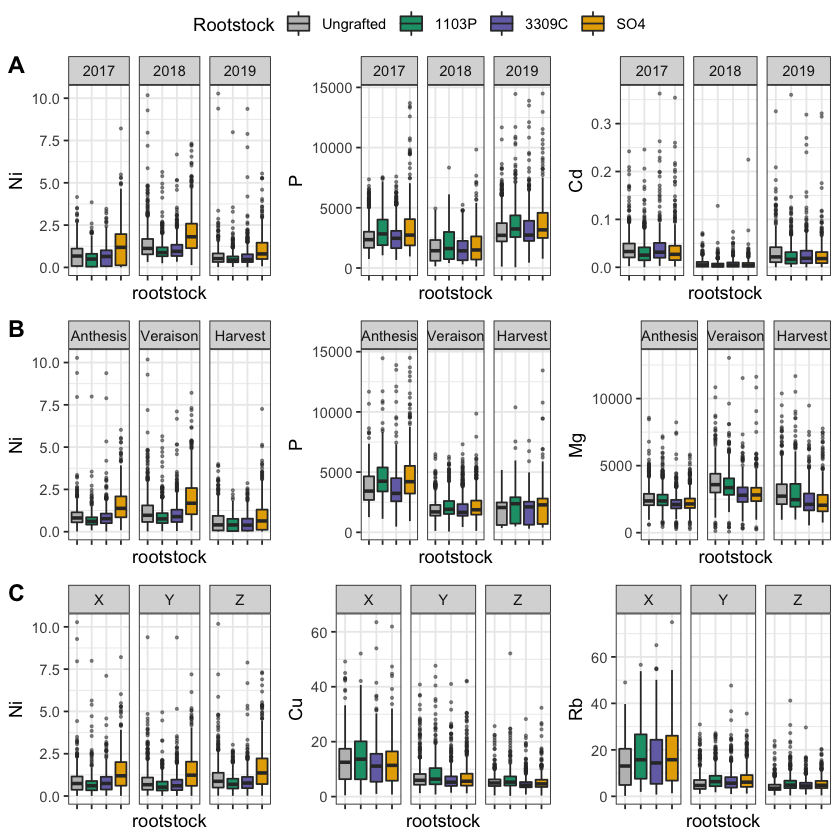

In [150]:
ggpubr::ggarrange(list_year[['Ni']], list_year[['P']], list_year[['Cd']],
                  list_phenology[['Ni']], list_phenology[['P']], list_phenology[['Mg']], 
                  list_leafpos[['Ni']], list_leafpos[['Cu']], list_leafpos[['Rb']],
                  ncol=3, nrow=3, labels=c('A', '', '', 'B', '', '', 'C', '', ''),
                  common.legend=T)

## Make Main Effects (Supplementary) Tables

In [39]:
#emmeans::emm_options(pbkrtest.limit = 7289, lmerTest.limit = 7289)
emmeans::emm_options(pbkrtest.limit = 3000, lmerTest.limit = 3000)

percent_diff <- function(x, y){
    return ((x - y) / y * 100)
}

mean_percent_diff <- function(emmeans_table, term, r1, r2){
    m1 <- emmeans_table[emmeans_table[[term]] == r1,'emmean']
    m2 <- emmeans_table[emmeans_table[[term]] == r2,'emmean']
    return (percent_diff(m1, m2))
}

make_summary_table <- function(ions, term, pairs){
    means_table <- list()
    summary_table <- list()
    
    for (ion in ions){
        emm_out <- emmeans::emmeans(models[[ion]], as.formula(str_interp("~${term}")), data=datasets[[ion]])
        emm_pairs <- as.data.frame(pairs(emm_out))

        emm_out <- as.data.frame(emm_out)
        emm_out$emmean <- exp((emm_out$emmean * sds[[ion]]) + means[[ion]])
        means_table[[ion]] <- emm_out$emmean

        comps <- c()
        for (comp in pairs) {
            r1 <- str_split(comp, '_')[[1]][1]
            r2 <- str_split(comp, '_')[[1]][2]

            percdiff <- mean_percent_diff(emm_out, term, r1, r2)
            p.val <- emm_pairs[emm_pairs$contrast == str_interp("${r1} - ${r2}"), 'p.value']
            #print (str_interp("${ion}: ${r1} - ${r2}: ${p.val}"))
            comps <- c(comps, percdiff, p.val)

        }
        summary_table[[ion]] <- comps
    }
    return (list(means_table=means_table, summary_table=summary_table))
}

#### Rootstock

In [42]:
# get means and % differences
rootstock_output <- make_summary_table(ions=rev(levels(PVE_plot$ion)),
                                       term='rootstock',
                                       pairs=c('Ungrafted_1103P', 'Ungrafted_3309C', 'Ungrafted_SO4', 
                                               '1103P_3309C', '1103P_SO4', '3309C_SO4'))

# write means table
write.csv(t(as.data.frame(rootstock_output$means_table)), file='1719_ionomics_rootstock_means.csv')
write.csv(PVE_plot[PVE_plot$factor == 'R', c('ion', 'PVE', 'p.adj')], file='1719_ionomics_rootstock_PVEs.csv')

# write % differences table
outputs <- t(as.data.frame(rootstock_output$summary_table))
colnames(outputs) <- c('Ungrafted_1103P', 'Ungrafted_1103P_p',
                      'Ungrafted_3309C', 'Ungrafted_3309C_p', 
                      'Ungrafted_SO4', 'Ungrafted_SO4_p', 
                      '1103P_3309C', '1103P_3309C_p', 
                      '1103P_SO4', '1103P_SO4_p', 
                      '3309C_SO4', '3309C_SO4_p')

write.csv(outputs, file='1719_ionomics_rootstock_posthocs.csv')

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7325' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7325' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7326' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7326)' or larger];
but 

#### Year

In [51]:
# get means and % differences
year_output <- make_summary_table(ions=rev(levels(PVE_plot$ion)),
                                       term='year',
                                       pairs=c('2017_2018', '2017_2019', '2018_2019'))

# write means table
write.csv(t(as.data.frame(year_output$means_table)), file='1719_ionomics_year_means.csv')
write.csv(PVE_plot[PVE_plot$factor == 'Y', c('ion', 'PVE', 'p.adj')], file='1719_ionomics_year_PVEs.csv')

# write % differences table
outputs <- t(as.data.frame(year_output$summary_table))
colnames(outputs) <- c('2017_2018', '2017_2018_p', 
                       '2017_2019', '2017_2019_p', 
                       '2018_2019', '2018_2019_p')

write.csv(outputs, file='1719_ionomics_year_posthocs.csv')

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7325' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7325' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7326' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7326)' or larger];
but 

In [53]:
# get means and % differences
phenology_output <- make_summary_table(ions=rev(levels(PVE_plot$ion)),
                                       term='phenology',
                                       pairs=c('Anthesis_Veraison', 'Anthesis_Harvest', 'Veraison_Harvest'))

# write means table
write.csv(t(as.data.frame(phenology_output$means_table)), file='1719_ionomics_phenology_means.csv')
write.csv(PVE_plot[PVE_plot$factor == 'P', c('ion', 'PVE', 'p.adj')], file='1719_ionomics_phenology_PVEs.csv')

# write % differences table
outputs <- t(as.data.frame(phenology_output$summary_table))
colnames(outputs) <- c('Anthesis_Veraison', 'Anthesis_Veraison_p',
                       'Anthesis_Harvest', 'Anthesis_Harvest_p',
                       'Veraison_Harvest', 'Veraison_Harvest_p')

write.csv(outputs, file='1719_ionomics_phenology_posthocs.csv')

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7325' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7325' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7326' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7326)' or larger];
but 

In [55]:
# get means and % differences
leafpos_output <- make_summary_table(ions=rev(levels(PVE_plot$ion)),
                                       term='leafpos',
                                       pairs=c('X_Y', 'X_Z', 'Y_Z'))

# write means table
write.csv(t(as.data.frame(leafpos_output$means_table)), file='1719_ionomics_leafpos_means.csv')
write.csv(PVE_plot[PVE_plot$factor == 'L', c('ion', 'PVE', 'p.adj')], file='1719_ionomics_leafpos_PVEs.csv')

# write % differences table
outputs <- t(as.data.frame(leafpos_output$summary_table))
colnames(outputs) <- c('X_Y', 'X_Y_p',
                       'X_Z', 'X_Z_p',
                       'Y_Z', 'Y_Z_p')

write.csv(outputs, file='1719_ionomics_leafpos_posthocs.csv')

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7325' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7325' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7325)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7326' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7326)' or larger];
but 

## 8. Clustering Ions by Main Effects

Here, I want a want a way to group ions by main effects so I have a reasonable way to talk about them in the results/discussion. Obvious answer is hierarchical clustering. I tried just clustering the ions based on their transformed concentration, and in an effect-centered way where I fit models and used REML to remove the effects of everything except that effect (and unexplainable variation). There, I just honed in on the idea that there are objective ionomic modules that could be further explored. 

Since I really wanted to focus on the ions *as they responded to the effect*, I decided to cluster on the emmeans output. Here, I decided to just cluster significant ions on 4 traits: adjusted mean, UCL and LCL. This, more or less, binned by coarse response pattern. 

Could these also be wrapped in a function? Yes

### First, cluster independent of effect

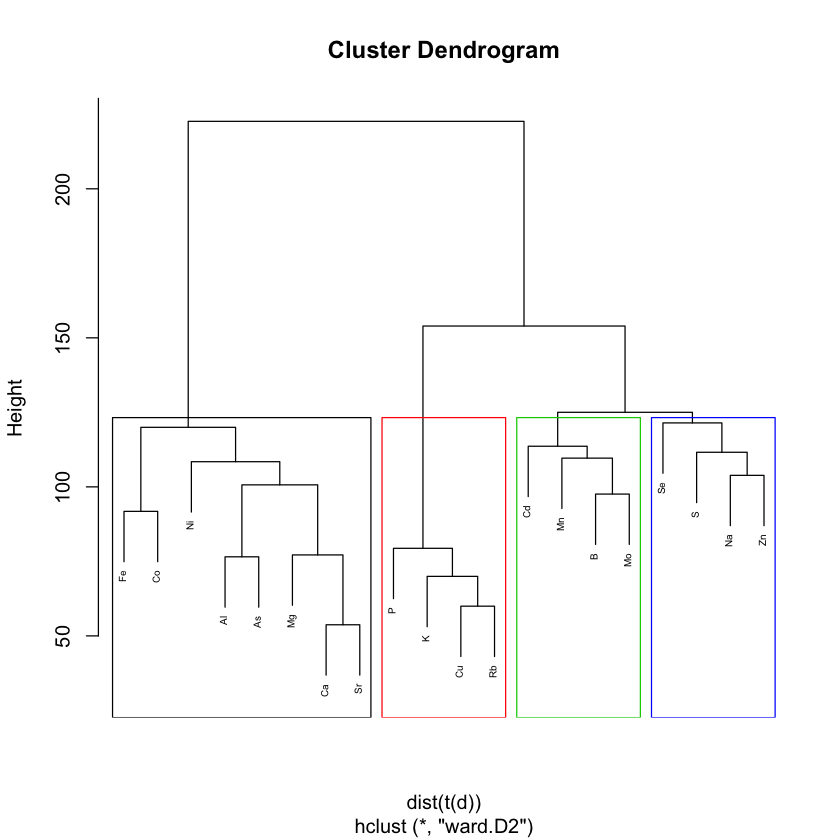

In [18]:
d <- vif %>% select(B:Cd)

rownames(d) <- d$samplename
d$samplename <- NULL

x <- hclust(dist(t(d)), method='ward.D2')
cl_members <- cutree(tree = x, k = 4)
plot(x = x, labels =  row.names(x), cex = 0.5)
rect.hclust(tree = x, k = 4, which = 1:4, border = 1:4, cluster = cl_members)

In [304]:
# I'm going for ...speed - Cake
emmeans::emm_options(pbkrtest.limit = 3000, lmerTest.limit = 3000)

### Year

In [308]:
d <- data.frame(year=rep(levels(vif$year), 3),
                term=c(rep('yvar', 3), rep('LCL', 3), rep('UCL', 3)))

ions <- rev(levels(PVE_plot_rs$ion))
ions

for (ion in ions){
    x <- emmeans::emmip(models[[ion]], ~year, CIs=T, plotit=F, data=datasets[[ion]])
    x <- x %>%     
        select(year, yvar, LCL, UCL) %>%
        gather(term, value, -year)
    d[[ion]] <- x$value
}

dim(d)
d$year <- NULL
d$term <- NULL

[1] "Al" "As" "B"  "Ca" "Cd" "Co" "Cu" "Fe" "K"  "Mg" "Mn" "Mo" "Na" "Ni" "P" 
[16] "Rb" "S"  "Se" "Sr" "Zn"

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.lim

Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation 

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions


[1]  9 22

In [310]:
x <- hclust(dist(t(d)), method='complete')
cl_members <- cutree(tree = x, k = 4)
pdf('1719_ionomics_hclust_year_logConc.pdf', width=8, height=6)
  plot(x = x, labels =  row.names(x), cex = 0.5)
dev.off()
#rect.hclust(tree = x, k = 4, which = 1:4, border = 1:4, cluster = cl_members)

pdf 
  2

### Phenology

In [340]:
x <- emmeans::emmip(models[['Ni']], ~phenology, CIs=T, plotit=F, data=datasets[['Ni']])

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7326' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7326' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions


In [311]:
d <- data.frame(phenology=rep(levels(vif$phenology), 3),
                term=c(rep('yvar', 3), rep('LCL', 3), rep('UCL', 3)))

ions <- rev(levels(PVE_plot_rs$ion))
ions

for (ion in ions){
    x <- emmeans::emmip(models[[ion]], ~phenology, CIs=T, plotit=F, data=datasets[[ion]])
    x <- x %>%
         select(phenology, yvar, LCL, UCL) %>%
         gather(term,value, -phenology)
    d[[ion]] <- x$value
}

dim(d)
d$phenology <- NULL
d$term <- NULL

[1] "Al" "As" "B"  "Ca" "Cd" "Co" "Cu" "Fe" "K"  "Mg" "Mn" "Mo" "Na" "Ni" "P" 
[16] "Rb" "S"  "Se" "Sr" "Zn"

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.lim

Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation 

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions


[1]  9 22

In [312]:
x <- hclust(dist(t(d)), method='complete')
cl_members <- cutree(tree = x, k = 4)
pdf('1719_ionomics_hclust_phenology_logConc.pdf', width=8, height=6)
plot(x = x, labels =  row.names(x), cex = 0.5)
dev.off()
#rect.hclust(tree = x, k = 4, which = 1:4, border = 1:4, cluster = cl_members)

pdf 
  2

### Leaf position

In [313]:
d <- data.frame(leafpos=rep(levels(vif$leafpos), 3),
                term=c(rep('yvar', 3), rep('LCL', 3), rep('UCL', 3)))

ions <- rev(levels(PVE_plot_rs$ion))
ions

for (ion in ions){
    x <- emmeans::emmip(models[[ion]], ~leafpos, CIs=T, plotit=F, data=datasets[[ion]])
    x <- x %>%
         select(leafpos, yvar, LCL, UCL) %>%
         gather(term,value, -leafpos)
    d[[ion]] <- x$value
}

dim(d)
d$leafpos <- NULL
d$term <- NULL

[1] "Al" "As" "B"  "Ca" "Cd" "Co" "Cu" "Fe" "K"  "Mg" "Mn" "Mo" "Na" "Ni" "P" 
[16] "Rb" "S"  "Se" "Sr" "Zn"

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.lim

Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation 

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions


[1]  9 22

In [314]:
x <- hclust(dist(t(d)), method='complete')
cl_members <- cutree(tree = x, k = 4)
pdf('1719_ionomics_hclust_leafpos_logConc.pdf', width=8, height=6)
plot(x = x, labels =  row.names(x), cex = 0.5)
#rect.hclust(tree = x, k = 4, which = 1:4, border = 1:4, cluster = cl_members)

### Rootstock

In [315]:
d <- data.frame(rootstock=rep(levels(vif$rootstock), 3),
                term=c(rep('yvar', 4), rep('LCL', 4), rep('UCL', 4)))

ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Al', 'Zn')])
ions

for (ion in ions){
    x <- emmeans::emmip(models[[ion]], ~rootstock, CIs=T, plotit=F, data=datasets[[ion]])
    x$yvar <- exp(x$yvar)
    x$LCL <- exp(x$LCL)
    x$UCL <- exp(x$UCL)
    x <- x %>%
         select(rootstock, yvar, LCL, UCL) %>%
         gather(term, value, -rootstock)
    d[[ion]] <- x$value
}

dim(d)
d$rootstock <- NULL
d$term <- NULL

[1] "As" "B"  "Ca" "Cd" "Co" "Cu" "Fe" "K"  "Mg" "Mn" "Mo" "Na" "Ni" "P"  "Rb"
[16] "S"  "Se" "Sr"

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7289' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.lim

Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7324' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7324)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7324' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7324)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation 

[1] 12 20

In [317]:
x <- hclust(dist(t(d)), method='complete')
cl_members <- cutree(tree = x, k = 4)
pdf('1719_ionomics_hclust_rootstock_logConc.pdf', width=8, height=6)
  plot(x = x, labels =  row.names(x), cex = 0.5)
dev.off()
#rect.hclust(tree = x, k = 4, which = 1:4, border = 1:4, cluster = cl_members)

pdf 
  2

## 9. Ion Clustering by Rootstock Interactions

In [223]:
## fuck it let's write a function

effectCluster <- function(f1, f2, ions){
    f1_levels <- levels(vif[[f1]])
    f2_levels <- levels(vif[[f2]])

    d <- data.frame(f1=rep(rep(f1_levels, each=length(f2_levels)), times=3),
                    f2=rep(f2_levels, times=length(f1_levels)*length(f2_levels)),
                    term=rep(c('yvar', 'LCL', 'UCL'), each=length(f1_levels)*length(f2_levels)))

    for (ion in ions){
        x <- emmeans::emmip(models[[ion]], 
                       as.formula(str_interp("~${f1}|${f2}")), 
                       CIs=T, plotit=F, data=datasets[[ion]])

        x <- x %>%
                 select(f1, f2, yvar, LCL, UCL) %>%
                 gather(term, value, -f1, -f2)

        d[,ion] <- x$value
        d[, "f1"] <- NULL
        d[, "f2"] <- NULL
        d[, "term"] <- NULL
    }

    x <- hclust(dist(t(d)), method='complete')
    plot(x = x, labels =  row.names(x), cex = 0.5)
    
}

### Rootstock by Year

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7328' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7328' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7328)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

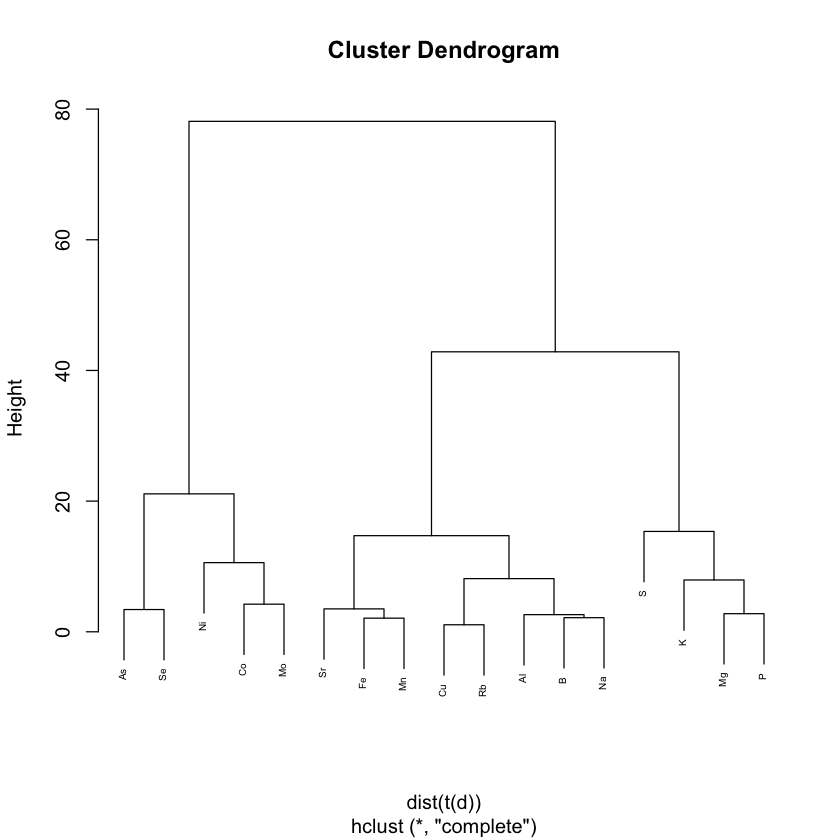

In [224]:
ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Ca', 'Cd', 'Zn')])

effectCluster(f1='rootstock', f2='year', ions)

### Rootstock by Phenology

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7326' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7326' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7326)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6970' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6970)' or larger];
but 

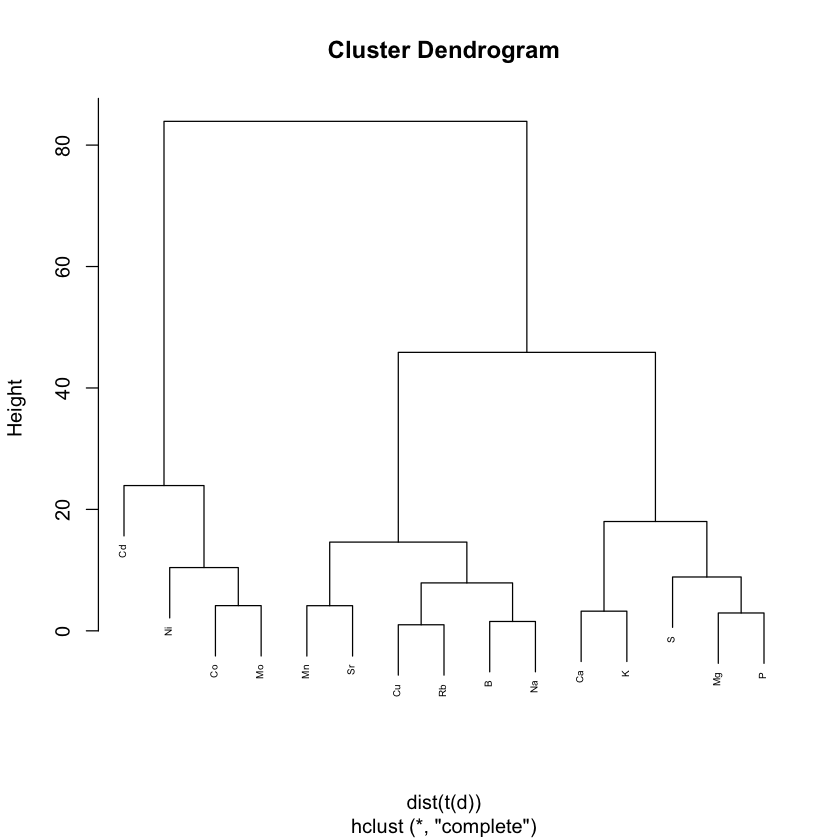

In [225]:
ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Al', 'As', 'Fe', 'Se', 'Zn')])

effectCluster(f1='rootstock', f2='phenology', ions)

### Rootstock by Leafpos

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7289' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7289' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7289)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory

NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6970' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6970)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 6970' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 6970)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but 

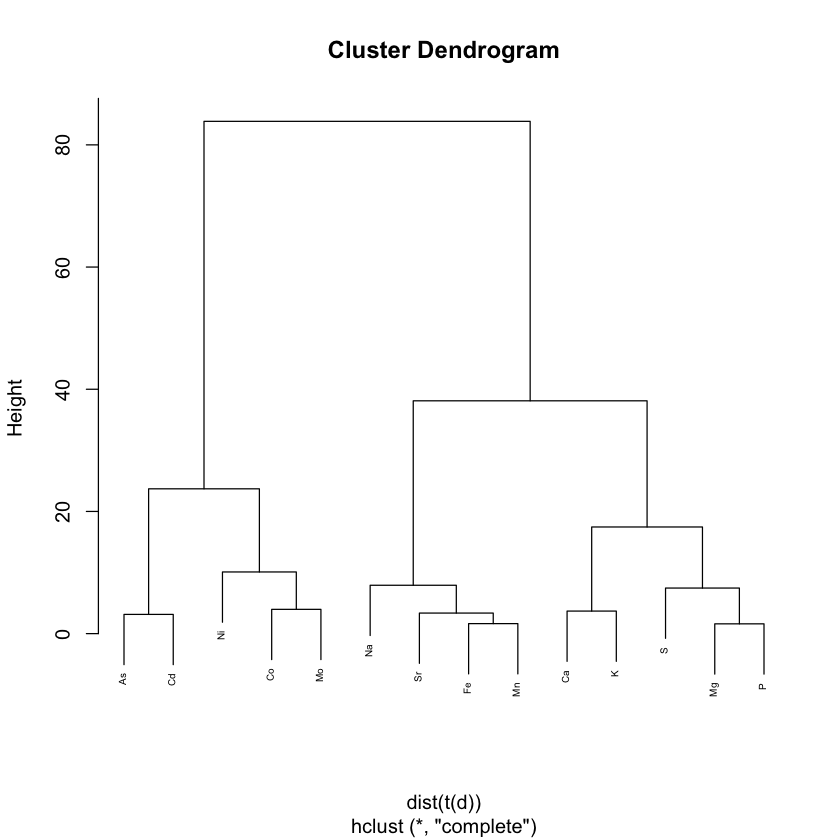

In [226]:
ions <- levels(PVE_plot_rs$ion)
ions <- rev(ions[!ions %in% c('Al', 'B', 'Cu', 'Rb', 'Se', 'Zn')])

effectCluster(f1='rootstock', f2='leafpos', ions)

## 10. Predicting Rootstock Parents

JEP fit a series of optimized random forests to predict the parent of the rootstocks to which a vine was grafted. Here I am taking the important features from those random forests and fitting a reduced mixed effect models to examine the effect of rootstock parents on ionomic variation. 

In [7]:
fit_parent_models <- function(d, parent, ions){
    control <- lmerControl(optimizer = "bobyqa")
    
    # figure out which rootstocks to set to true
    if (parent == 'riparia'){
        rootstocks <- c('3309C', 'SO4')
    } else if (parent == 'rupestris') {
        rootstocks <- c('1103P', '3309C')
    } else {
        rootstocks <- c('1103P', 'SO4')
    }
    
    # remove ungrafted
    d <- d[d$rootstock != 'Ungrafted',]
    
    # recode rootstock + create vine_id
    d$hasParent <- as.factor(d$rootstock %in% rootstocks)
    d$vine_id <- paste(d$row, d$cell, d$replicate, sep='')
    print(table(d$hasParent))
    
    # create things to return
    datasets <- list()
    means <- list()
    sds <- list()
    models <- list()
    PVEs <- list()
    ps <- list()
    
    for (ion in ions){
        d_sub <- d %>% select(ion, hasParent, year, phenology, leafpos, vine_id, block)
        colnames(d_sub) <- c('element', 'hasParent', 'year', 'phenology', 'leafpos', 'vine_id', 'block')
        
        #filter for safety
        d_sub <- d_sub[d_sub$element > 0, ]
        
        # log for residuals, z-score for model comparison 
        d_sub$element <- log(d_sub$element)
        means[[ion]] <- mean(d_sub$element)
        sds[[ion]] <- sd(d_sub$element)
        d_sub$element <- scale(d_sub$element)
        
        # fit model, get anova
        lmod <- lmerTest::lmer(element ~ year*phenology*leafpos*hasParent  + (1|vine_id) + (1|block), data=d_sub, control=control)
        laov <- anova(lmod, type=3, test.stastic='F')
        models[[ion]] <- lmod
        
        ## get PVEs
        SS_is <- laov['hasParent',]$Sum
        SS_yr <- laov['year:hasParent',]$Sum
        SS_ph <- laov['phenology:hasParent',]$Sum
        SS_lp <- laov['leafpos:hasParent',]$Sum
        SS_res <- sum(resid(lmod)^2)
        PVEs[[ion]] <- c(SS_is/SS_res*100, SS_yr/SS_res*100, SS_ph/SS_res*100, SS_lp/SS_res*100)
        ps[[ion]] <- laov$Pr
    }
    
    # return list of things
    return (list(datasets=datasets, means=means, sds=sds, models=models, PVEs=PVEs, ps=ps))
    
}

### Riparia

In [13]:
isRiparia <- fit_parent_models(d=vif_raw, parent='riparia', ions=sort(levels(PVE_plot$ion)))


FALSE  TRUE 
 1834  3628 


boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular


In [16]:
m <- t(as.data.frame(isRiparia$PVEs))
colnames(m) <- c('isRiparia', 'year:isRiparia', 'phenology:isRiparia', 'leafpos:isRiparia')
m

,isRiparia,year:isRiparia,phenology:isRiparia,leafpos:isRiparia
Al,0.003062904,0.260969926,0.100529278,0.003436224
As,0.157126586,0.094785924,0.032478092,0.210080350
B,0.031122995,0.144988026,0.115015573,0.003818617
Ca,0.012155422,0.075933838,0.513662870,0.050026676
Cd,0.794172811,0.008498879,0.157485167,0.043001365
Co,0.544719003,0.798017906,7.554665972,0.119854749
Cu,1.841099951,0.380743104,0.313335275,0.063515188
Fe,1.943247869,0.047310230,0.008450075,0.317794392
K,0.029833961,0.192104655,0.259004876,0.161542769
Mg,2.734477177,0.442026762,0.271701640,0.814049549


In [17]:
p_rip <- t(as.data.frame(isRiparia$ps))
colnames(p_rip) <- c('year', 'phenology', 'leafpos', 'hasParent', 'year:phenology', 'year:leafpos', 
                 'phenology:leafpos', 'year:hasParent', 'phenology:hasParent', 'leafpos:hasParent',
                 'year:phenology:leafpos', 'year:phenology:hasParent', 'year:leafpos:hasParent', 
                 'phenology:leafpos:hasParent', 'year:phenology:leafpos:hasParent') 

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 5461' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 5461)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 5461' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 5461)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 5461' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 5461)' or larger];
but be warned that this may result in large computation time and memory

pdf 
  2

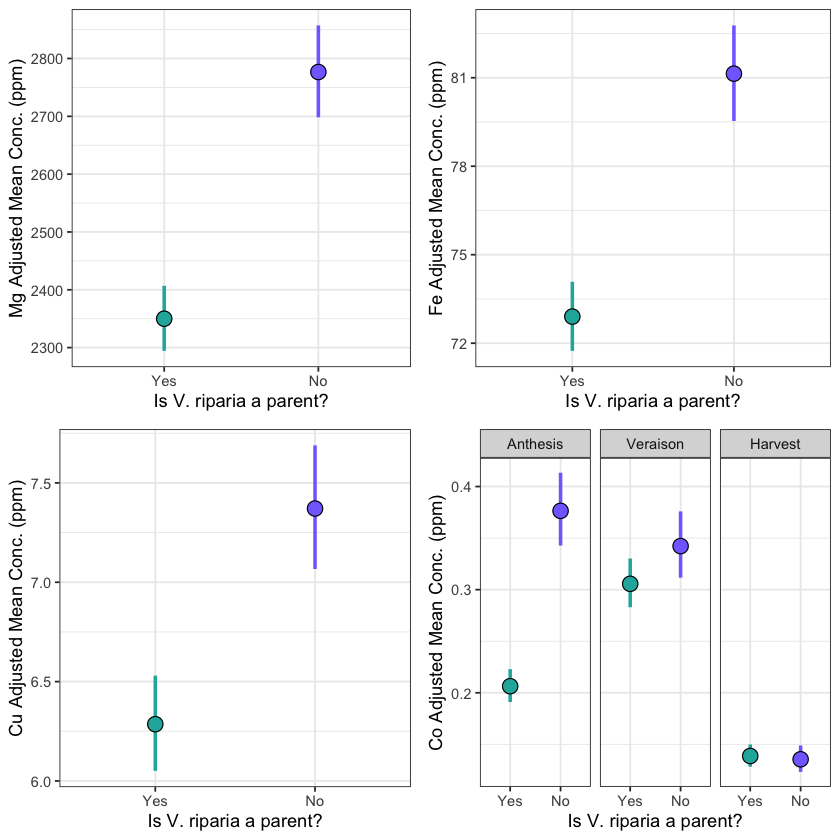

In [333]:
ions <- c('Mg', 'Fe', 'Cu', 'Ni')
rip_plots <- list()
for (ion in ions){
    emm_plot <- emmeans::emmip(isRiparia$models[[ion]], ~hasParent, plotit=F, CIs=T)
    emm_plot$yvar <- exp((emm_plot$yvar * isRiparia$sds[[ion]]) + isRiparia$means[[ion]])
    emm_plot$LCL <- exp((emm_plot$LCL * isRiparia$sds[[ion]]) + isRiparia$means[[ion]]) 
    emm_plot$UCL <- exp((emm_plot$UCL * isRiparia$sds[[ion]]) + isRiparia$means[[ion]])
    emm_plot$hasParent <- factor(emm_plot$hasParent, levels=c('TRUE', 'FALSE'), labels=c('Yes','No'))
    
    p <- ggplot(emm_plot, aes(x=hasParent, y=yvar, ymin=LCL, ymax=UCL, color=hasParent, fill=hasParent)) + 
      geom_linerange(lwd=1) + 
      geom_point(size=4, shape=21, color='black') + 
      scale_color_manual('', values=c('lightseagreen', 'lightslateblue')) + 
      scale_fill_manual('', values=c('lightseagreen', 'lightslateblue')) + 
      ylab(str_interp("${ion} Adjusted Mean Conc. (ppm)")) + 
      xlab("Is V. riparia a parent?") + 
      theme_bw()
    
    rip_plots[[ion]] <- p
}

#cobalt
emm_plot <- emmeans::emmip(isRiparia$models[['Co']], ~hasParent|phenology, plotit=F, CIs=T)
emm_plot$yvar <- exp((emm_plot$yvar * isRiparia$sds[['Co']]) + isRiparia$means[['Co']])
emm_plot$LCL <- exp((emm_plot$LCL * isRiparia$sds[['Co']]) + isRiparia$means[['Co']]) 
emm_plot$UCL <- exp((emm_plot$UCL * isRiparia$sds[['Co']]) + isRiparia$means[['Co']])
emm_plot$hasParent <- factor(emm_plot$hasParent, levels=c('TRUE', 'FALSE'), labels=c('Yes','No'))
p <- ggplot(emm_plot, aes(x=hasParent, y=yvar, ymin=LCL, ymax=UCL, color=hasParent, fill=hasParent)) + 
  geom_linerange(lwd=1) + 
  geom_point(size=4, shape=21, color='black') + 
  scale_color_manual('', values=c('lightseagreen', 'lightslateblue')) + 
  scale_fill_manual('', values=c('lightseagreen', 'lightslateblue')) + 
  ylab(str_interp("Co Adjusted Mean Conc. (ppm)")) + 
  xlab("Is V. riparia a parent?") + 
  facet_wrap('phenology') + 
  theme_bw()


ggpubr::ggarrange(rip_plots[['Mg']], rip_plots[['Fe']], rip_plots[['Cu']], p,
                 ncol=2, nrow=2, legend='none')


pdf('Rootstock_paper/Figures/Figure_4a.pdf', height=4, width=8)
ggpubr::ggarrange(rip_plots[['Mg']], p,
                 ncol=2, nrow=1, legend='none', labels=c('A', ''))
dev.off()

### Rupestris

In [18]:
isRupestris <- fit_parent_models(d=vif_raw, parent='rupestris', ions=sort(levels(PVE_plot$ion)))
m <- t(as.data.frame(isRupestris$PVEs))
colnames(m) <- c('isRupestris', 'year:isRupestris', 'phenology:isRupestris', 'leafpos:isRupestris')
m

p_rup <- t(as.data.frame(isRupestris$ps))
colnames(p_rup) <- c('year', 'phenology', 'leafpos', 'hasParent', 'year:phenology', 'year:leafpos', 
                 'phenology:leafpos', 'year:hasParent', 'phenology:hasParent', 'leafpos:hasParent',
                 'year:phenology:leafpos', 'year:phenology:hasParent', 'year:leafpos:hasParent', 
                 'phenology:leafpos:hasParent', 'year:phenology:leafpos:hasParent') 


FALSE  TRUE 
 1818  3644 


boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular


,isRupestris,year:isRupestris,phenology:isRupestris,leafpos:isRupestris
Al,0.04308667,0.141869272,0.032504210,0.131814809
As,0.48824720,0.496642330,0.033079661,0.428428903
B,0.69013770,0.041508838,0.029560851,0.042662028
Ca,1.04929893,0.043247267,0.075506284,0.307789040
Cd,0.01272150,0.094971276,0.037347111,0.033265265
Co,0.10912415,0.103029145,2.439390895,0.611218005
Cu,0.03794955,0.173508407,0.129999548,0.001242540
Fe,0.09562257,0.067029678,0.068792417,0.021630967
K,0.11296662,0.141610450,0.067467053,0.021976587
Mg,0.37100278,0.113843619,0.298092893,0.017560313


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 5460' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 5460)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 5460' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 5460)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 5461' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 5461)' or larger];
but be warned that this may result in large computation time and memory

pdf 
  2

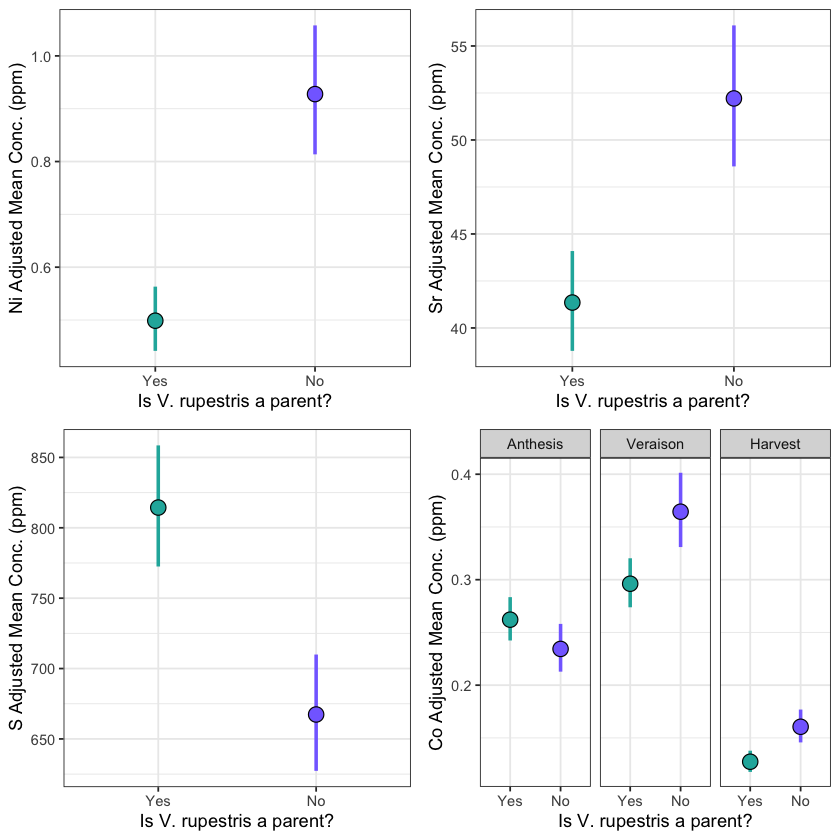

In [332]:
ions <- c('Ni', 'Sr', 'S')
rup_plots <- list()
for (ion in ions){
    emm_plot <- emmeans::emmip(isRupestris$models[[ion]], ~hasParent, plotit=F, CIs=T)
    emm_plot$yvar <- exp((emm_plot$yvar * isRupestris$sds[[ion]]) + isRupestris$means[[ion]])
    emm_plot$LCL <- exp((emm_plot$LCL * isRupestris$sds[[ion]]) + isRupestris$means[[ion]]) 
    emm_plot$UCL <- exp((emm_plot$UCL * isRupestris$sds[[ion]]) + isRupestris$means[[ion]])
    emm_plot$hasParent <- factor(emm_plot$hasParent, levels=c('TRUE', 'FALSE'), labels=c('Yes','No'))
    
    p <- ggplot(emm_plot, aes(x=hasParent, y=yvar, ymin=LCL, ymax=UCL, color=hasParent, fill=hasParent)) + 
      geom_linerange(lwd=1) + 
      geom_point(size=4, shape=21, color='black') + 
      scale_color_manual('', values=c('lightseagreen', 'lightslateblue')) + 
      scale_fill_manual('', values=c('lightseagreen', 'lightslateblue')) + 
      ylab(str_interp("${ion} Adjusted Mean Conc. (ppm)")) + 
      xlab("Is V. rupestris a parent?") + 
      theme_bw()
    
    rup_plots[[ion]] <- p
}

#cobalt
emm_plot <- emmeans::emmip(isRupestris$models[['Co']], ~hasParent|phenology, plotit=F, CIs=T)
emm_plot$yvar <- exp((emm_plot$yvar * isRupestris$sds[['Co']]) + isRupestris$means[['Co']])
emm_plot$LCL <- exp((emm_plot$LCL * isRupestris$sds[['Co']]) + isRupestris$means[['Co']]) 
emm_plot$UCL <- exp((emm_plot$UCL * isRupestris$sds[['Co']]) + isRupestris$means[['Co']])
emm_plot$hasParent <- factor(emm_plot$hasParent, levels=c('TRUE', 'FALSE'), labels=c('Yes','No'))
p <- ggplot(emm_plot, aes(x=hasParent, y=yvar, ymin=LCL, ymax=UCL, color=hasParent, fill=hasParent)) + 
  geom_linerange(lwd=1) + 
  geom_point(size=4, shape=21, color='black') + 
  scale_color_manual('', values=c('lightseagreen', 'lightslateblue')) + 
  scale_fill_manual('', values=c('lightseagreen', 'lightslateblue')) + 
  ylab(str_interp("Co Adjusted Mean Conc. (ppm)")) + 
  xlab("Is V. rupestris a parent?") + 
  facet_wrap('phenology') + 
  theme_bw()


ggpubr::ggarrange(rup_plots[['Ni']], rup_plots[['Sr']], rup_plots[['S']], p,
                 ncol=2, nrow=2, legend='none')

pdf("Rootstock_paper/Figures/Figure_4b.pdf", height=4, width=8)
ggpubr::ggarrange(rup_plots[['Ni']], p,
                 ncol=2, nrow=1, legend='none', labels=c('B',''))
dev.off()

### Berlandieri

In [19]:
isBerlandieri <- fit_parent_models(d=vif_raw, parent='berlandieri', ions=sort(levels(PVE_plot$ion)))
m <- t(as.data.frame(isBerlandieri$PVEs))
colnames(m) <- c('isBerlandieri', 'year:isBerlandieri', 'phenology:isBerlandieri', 'leafpos:isBerlandieri')
m

p_ber <- t(as.data.frame(isBerlandieri$ps))
colnames(p_ber) <- c('year', 'phenology', 'leafpos', 'hasParent', 'year:phenology', 'year:leafpos', 
                 'phenology:leafpos', 'year:hasParent', 'phenology:hasParent', 'leafpos:hasParent',
                 'year:phenology:leafpos', 'year:phenology:hasParent', 'year:leafpos:hasParent', 
                 'phenology:leafpos:hasParent', 'year:phenology:leafpos:hasParent') 


FALSE  TRUE 
 1810  3652 


boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular


,isBerlandieri,year:isBerlandieri,phenology:isBerlandieri,leafpos:isBerlandieri
Al,0.02224409,0.018022917,1.318661e-01,0.1131176984
As,1.55155192,0.694718905,1.831252e-04,1.0218575428
B,0.37843591,0.242519175,2.711577e-01,0.0725463750
Ca,1.43109496,0.005251109,4.463289e-01,0.5682885989
Cd,1.09938488,0.124662797,1.897932e-01,0.1322760936
Co,1.43333304,0.980009327,1.319620e+00,0.1940294590
Cu,1.07267715,0.148094929,5.235651e-02,0.0719045764
Fe,0.84663585,0.110092893,1.005997e-01,0.3137540062
K,0.02638614,0.013530710,2.889474e-01,0.2316977611
Mg,0.53306170,0.163227934,4.565304e-02,0.9111555118


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 5461' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 5461)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 5461' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 5461)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 5139' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 5139)' or larger];
but be warned that this may result in large computation time and memory

pdf 
  2

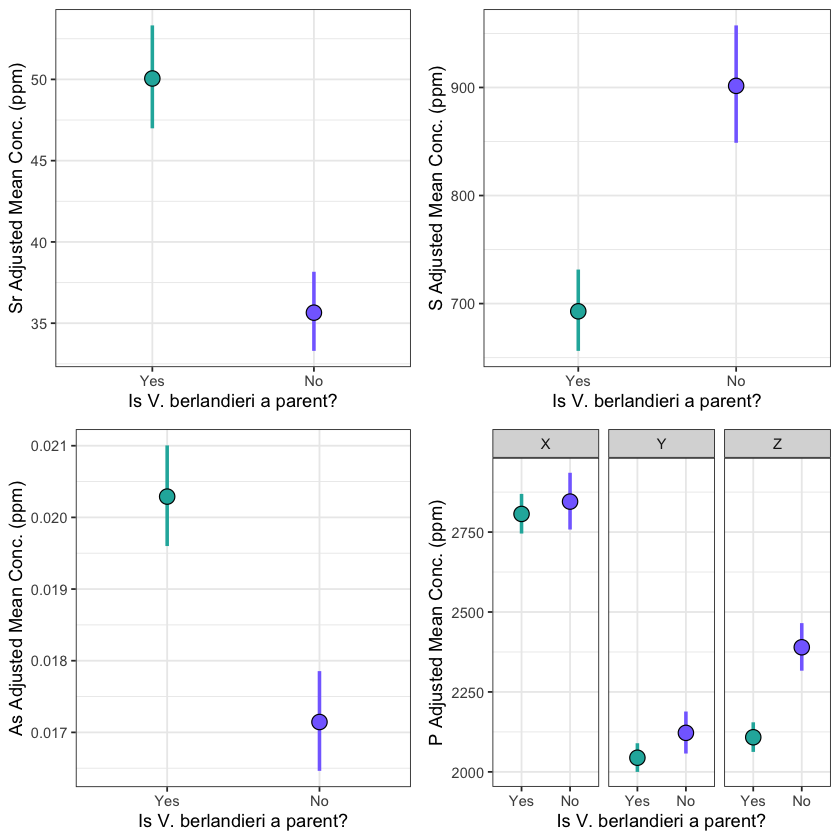

In [34]:
ions <- c('Sr', 'S', 'As')
ber_plots <- list()
for (ion in ions){
    emm_plot <- emmeans::emmip(isBerlandieri$models[[ion]], ~hasParent, plotit=F, CIs=T)
    emm_plot$yvar <- exp((emm_plot$yvar * isBerlandieri$sds[[ion]]) + isBerlandieri$means[[ion]])
    emm_plot$LCL <- exp((emm_plot$LCL * isBerlandieri$sds[[ion]]) + isBerlandieri$means[[ion]]) 
    emm_plot$UCL <- exp((emm_plot$UCL * isBerlandieri$sds[[ion]]) + isBerlandieri$means[[ion]])
    emm_plot$hasParent <- factor(emm_plot$hasParent, levels=c('TRUE', 'FALSE'), labels=c('Yes','No'))
    
    p <- ggplot(emm_plot, aes(x=hasParent, y=yvar, ymin=LCL, ymax=UCL, color=hasParent, fill=hasParent)) + 
      geom_linerange(lwd=1) + 
      geom_point(size=4, shape=21, color='black') + 
      scale_color_manual('', values=c('lightseagreen', 'lightslateblue')) + 
      scale_fill_manual('', values=c('lightseagreen', 'lightslateblue')) + 
      ylab(str_interp("${ion} Adjusted Mean Conc. (ppm)")) + 
      xlab("Is V. berlandieri a parent?") + 
      theme_bw()
    
    ber_plots[[ion]] <- p
}

#phosphorus
emm_plot <- emmeans::emmip(isRupestris$models[['P']], ~hasParent|leafpos, plotit=F, CIs=T)
emm_plot$yvar <- exp((emm_plot$yvar * isBerlandieri$sds[['P']]) + isBerlandieri$means[['P']])
emm_plot$LCL <- exp((emm_plot$LCL * isBerlandieri$sds[['P']]) + isBerlandieri$means[['P']]) 
emm_plot$UCL <- exp((emm_plot$UCL * isBerlandieri$sds[['P']]) + isBerlandieri$means[['P']])
emm_plot$hasParent <- factor(emm_plot$hasParent, levels=c('TRUE', 'FALSE'), labels=c('Yes','No'))
p <- ggplot(emm_plot, aes(x=hasParent, y=yvar, ymin=LCL, ymax=UCL, color=hasParent, fill=hasParent)) + 
  geom_linerange(lwd=1) + 
  geom_point(size=4, shape=21, color='black') + 
  scale_color_manual('', values=c('lightseagreen', 'lightslateblue')) + 
  scale_fill_manual('', values=c('lightseagreen', 'lightslateblue')) + 
  ylab(str_interp("P Adjusted Mean Conc. (ppm)")) + 
  xlab("Is V. berlandieri a parent?") + 
  facet_wrap('leafpos') + 
  theme_bw()


ggpubr::ggarrange(ber_plots[['Sr']], ber_plots[['S']], ber_plots[['As']], p,
                 ncol=2, nrow=2, legend='none')

pdf("Rootstock_paper/Figures/Figure_4c.pdf", width=8, height=4)
ggpubr::ggarrange(ber_plots[['Sr']], p,
                 ncol=2, nrow=1, legend='none', labels=c('C', ''))
dev.off()

### make P-value table, with correction

In [20]:
colnames(p_rip) <- colnames(p_rip) %>% str_replace('^', 'riparia_')
colnames(p_rup) <- colnames(p_rup) %>% str_replace('^', 'rupestris_')
colnames(p_ber) <- colnames(p_ber) %>% str_replace('^', 'berlandieri_')

In [31]:
p_tab <- as.data.frame(cbind(p_rip, p_rup, p_ber))
p_tab$ion <- rownames(p_tab)
p_tab <- p_tab %>% gather('factor', 'p_value', -ion)
p_tab$p.adj <- p.adjust(p_tab$p_value, method='bonferroni')


# log10 for easier viewing
p_tab$log10_p_value <- round(log10(p_tab$p_value), 2)
p_tab$log10_p.adj <- round(log10(p_tab$p.adj), 2)

p_tab$log10_p_value[p_tab$log10_p_value > log10(0.05)] <- NA
p_tab$log10_p.adj[p_tab$log10_p.adj > log10(0.05)] <- NA
# p_tab <- p_tab %>% unite('p.adj', p_value, p.adj, sep=' // ')
# p_tab <- p_tab %>% spread('factor', 'p.adj')

p_tab <- p_tab[str_detect(p_tab$factor, "hasParent"), ]
write.csv(p_tab, file='1719_ionomics_hasParent.csv', row.names=F)
write.csv(na.omit(p_tab), file='1719_ionomics_hasParent_FILT.csv', row.names=F)

In [68]:
#na.omit(p_tab[str_detect(p_tab$factor, "rupestris_has"),])
table(na.omit(p_tab[str_detect(p_tab$factor, "rupestris"),])$ion)
levels(PVE_plot$ion)[!(levels(PVE_plot$ion) %in% names(table(na.omit(p_tab[str_detect(p_tab$factor, "rupestris"),])$ion)))]


As  B Ca Co Mg Mn Mo Ni  P  S Se Sr 
 3  1  1  3  1  1  3  2  1  3  1  1 

[1] "Zn" "Rb" "Na" "K"  "Fe" "Cu" "Cd" "Al"

In [69]:
rip <- levels(PVE_plot$ion)[!(levels(PVE_plot$ion) %in% 
                       names(table(na.omit(p_tab[str_detect(p_tab$factor, "riparia"),])$ion)))]

rup <- levels(PVE_plot$ion)[!(levels(PVE_plot$ion) %in% 
                       names(table(na.omit(p_tab[str_detect(p_tab$factor, "rupestris"),])$ion)))]

ber <- levels(PVE_plot$ion)[!(levels(PVE_plot$ion) %in% 
                       names(table(na.omit(p_tab[str_detect(p_tab$factor, "berlandieri"),])$ion)))]

intersect(intersect(rip, rup), ber)

[1] "Zn" "Na" "K"  "Al"

### Compare to Gautier 2020

In [363]:
isRiparia_vec <- c('3309C', 'SO4')
vif_rs <- vif
vif_rs <- vif[vif$rootstock != 'Ungrafted',]
vif_rs$isRiparia <- as.factor(vif_rs$rootstock %in% isRiparia_vec)
vif_rs$vine_id <- paste(vif_rs$row, vif_rs$cell, vif_rs$replicate, sep='')
table(vif_rs$isRiparia)


FALSE  TRUE 
 1834  3628 

Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
isRiparia 20.333  20.333     1 210.68  19.246 1.816e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
isRiparia 113.01  113.01     1 214.54   132.9 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF  DenDF F value Pr(>F)
isRiparia 1.0084  1.0084     1 195.63  0.9421 0.3329


boundary (singular) fit: see ?isSingular


Type III Analysis of Variance Table with Satterthwaite's method
            Sum Sq  Mean Sq NumDF DenDF F value Pr(>F)
isRiparia 0.014752 0.014752     1  5460  0.0145 0.9041
Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF DenDF F value  Pr(>F)  
isRiparia 3.3246  3.3246     1 199.9  3.4357 0.06528 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


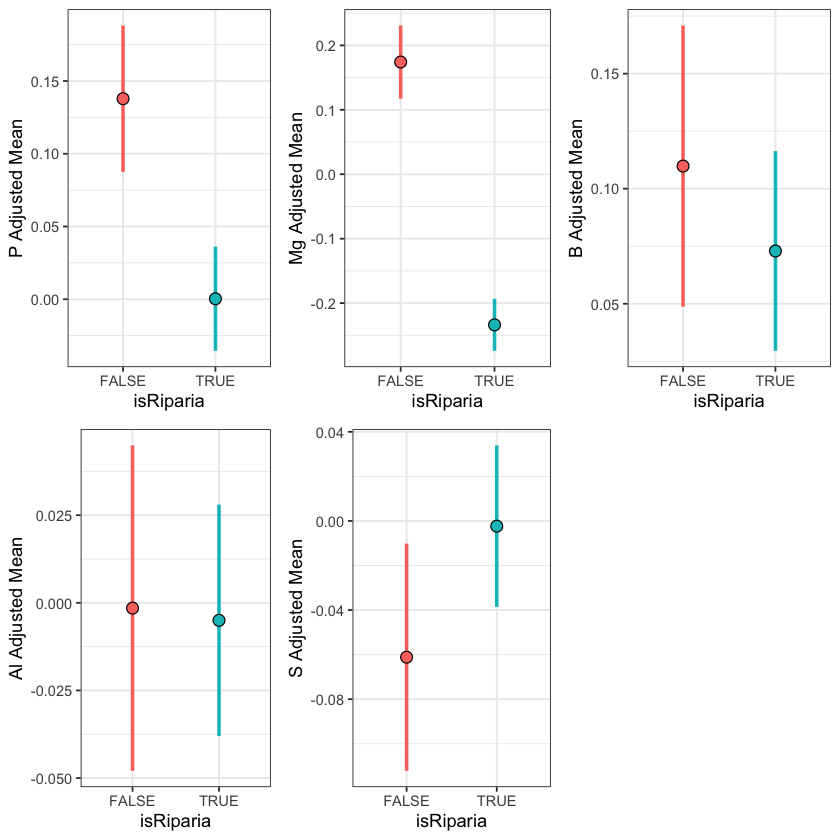

In [366]:
ions <- c('P', 'Mg', 'B', 'Al', 'S')
rip_plots <- list()

for (ion in ions){
    d <- vif_rs %>% select(ion, isRiparia, vine_id)
    colnames(d) <- c('element', 'isRiparia', 'vine_id')
    lmod <- lmerTest::lmer(element ~ isRiparia + (1|vine_id), data=d)
    laov <- anova(lmod, type=3, test.statistic='F')
    print(laov)
    emm_plot <- emmeans::emmip(lmod, ~isRiparia, CIs=T, plotit=F)
    p <- ggplot(emm_plot, aes(x=isRiparia, y=yvar, ymin=LCL, ymax=UCL, color=isRiparia, fill=isRiparia)) + 
      geom_linerange(lwd=1) + 
      geom_point(size=3, shape=21, color='black') + 
      ylab(str_interp("${ion} Adjusted Mean")) + 
      theme_bw()
    
    rip_plots[[ion]] <- p    
}


ggpubr::ggarrange(rip_plots[['P']], rip_plots[['Mg']], rip_plots[['B']], 
                  rip_plots[['Al']], rip_plots[['S']],
                 nrow=2, ncol=3, legend=F)


In [368]:
isRupestris_vec <- c('1103P', '3309C')
vif_rs <- vif
vif_rs <- vif[vif$rootstock != 'Ungrafted',]
vif_rs$isRupestris <- as.factor(vif_rs$rootstock %in% isRupestris_vec)
vif_rs$vine_id <- paste(vif_rs$row, vif_rs$cell, vif_rs$replicate, sep='')
table(vif_rs$isRupestris)


FALSE  TRUE 
 1818  3644 

Type III Analysis of Variance Table with Satterthwaite's method
            Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
isRupestris 18.853  18.853     1 212.52  17.846 3.553e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Type III Analysis of Variance Table with Satterthwaite's method
            Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
isRupestris 26.367  26.367     1 197.28  24.633 1.496e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Type III Analysis of Variance Table with Satterthwaite's method
            Sum Sq Mean Sq NumDF  DenDF F value  Pr(>F)  
isRupestris 6.7751  6.7751     1 212.18  6.7148 0.01023 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


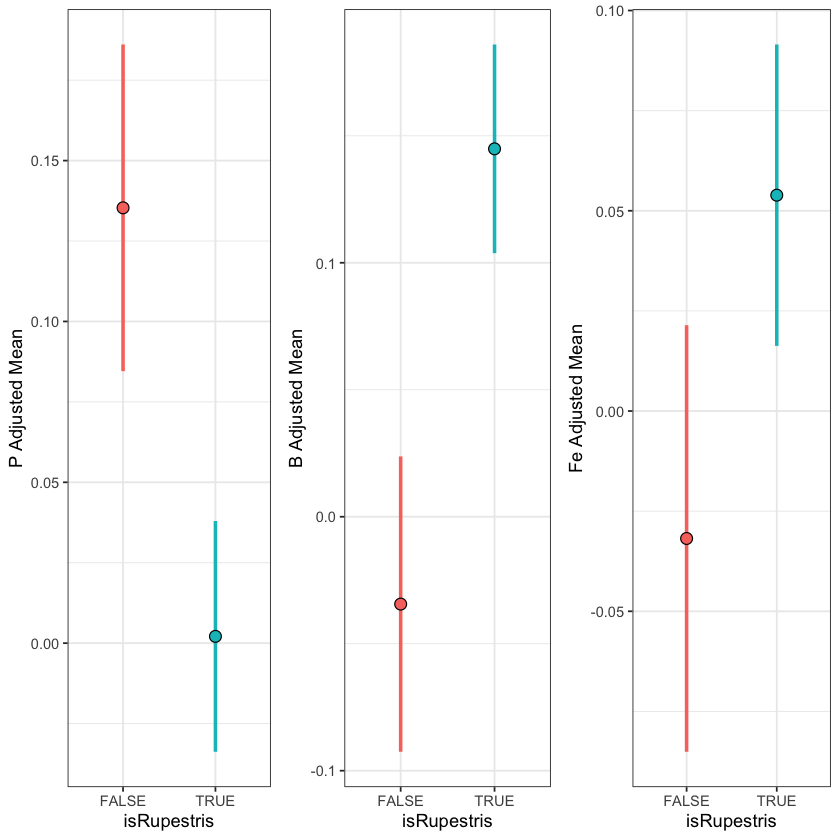

In [370]:
ions <- c('P', 'B', 'Fe')
rup_plots <- list()

for (ion in ions){
    d <- vif_rs %>% select(ion, isRupestris, vine_id)
    colnames(d) <- c('element', 'isRupestris', 'vine_id')
    lmod <- lmerTest::lmer(element ~ isRupestris + (1|vine_id), data=d)
    laov <- anova(lmod, type=3, test.statistic='F')
    print(laov)
    emm_plot <- emmeans::emmip(lmod, ~isRupestris, CIs=T, plotit=F)
    p <- ggplot(emm_plot, aes(x=isRupestris, y=yvar, ymin=LCL, ymax=UCL, color=isRupestris, fill=isRupestris)) + 
      geom_linerange(lwd=1) + 
      geom_point(size=3, shape=21, color='black') + 
      ylab(str_interp("${ion} Adjusted Mean")) + 
      theme_bw()
    
    rup_plots[[ion]] <- p    
}


ggpubr::ggarrange(rup_plots[['P']], rup_plots[['B']], rup_plots[['Fe']], 
                 nrow=1, ncol=3, legend=F)

In [250]:
## Scratch

In [290]:
colnames(vif_raw)

[1] "samplename" "B"          "Na"         "Mg"         "Al"        
 [6] "P"          "S"          "K"          "Ca"         "Fe"        
[11] "Mn"         "Co"         "Ni"         "Cu"         "Zn"        
[16] "As"         "Se"         "Rb"         "Sr"         "Mo"        
[21] "Cd"         "X"          "year"       "phenology"  "row"       
[26] "replicate"  "cell"       "leafpos"    "treatment"  "block"     
[31] "rootstock"  "vine_id"

In [297]:
lmod.Ni <- lmerTest::lmer( scale(log(Ni)) ~ treatment + year*phenology*rootstock*leafpos + (1|vine_id) + (1|block), data=vif_raw )
lmod.Mo <- lmerTest::lmer( scale(log(Mo)) ~ treatment + year*phenology*rootstock*leafpos + (1|vine_id) + (1|block), data=vif_raw )
lmod.Mg <- lmerTest::lmer( scale(log(Mg)) ~ treatment + year*phenology*rootstock*leafpos + (1|vine_id) + (1|block), data=vif_raw )


performance::model_performance(lmod.Ni)
log(shapiro.test(sample(resid(lmod.Ni), 4999))$p.value)

performance::model_performance(lmod.Mo)
log(shapiro.test(sample(resid(lmod.Mo), 4999))$p.value)

performance::model_performance(lmod.Mg)
log(shapiro.test(sample(resid(lmod.Mg), 4999))$p.value)






Warning message in log(Ni):
“NaNs produced”Warning message in log(Ni):
“NaNs produced”Warning message in log(Ni):
“NaNs produced”Warning message in log(Ni):
“NaNs produced”Warning message in log(Ni):
“NaNs produced”Warning message in log(Ni):
“NaNs produced”Warning message in log(Mo):
“NaNs produced”Warning message in log(Mo):
“NaNs produced”Warning message in log(Mo):
“NaNs produced”Warning message in log(Mo):
“NaNs produced”Warning message in log(Mo):
“NaNs produced”Warning message in log(Mo):
“NaNs produced”Warning message in log(Mg):
“NaNs produced”Warning message in log(Mg):
“NaNs produced”Warning message in log(Mg):
“NaNs produced”Warning message in log(Mg):
“NaNs produced”Warning message in log(Mg):
“NaNs produced”Warning message in log(Mg):
“NaNs produced”

AIC,BIC,R2_conditional,R2_marginal,ICC,RMSE,Sigma
8037.963,8817.57,0.8599937,0.7883733,0.3384282,0.3651696,0.3747319


[1] -98.00749

AIC,BIC,R2_conditional,R2_marginal,ICC,RMSE,Sigma
17155.3,17934.88,0.5100982,0.3558957,0.2394062,0.6922988,0.7099613


[1] -88.65374

AIC,BIC,R2_conditional,R2_marginal,ICC,RMSE,Sigma
16975.27,17754.89,0.4889665,0.4553923,0.06164853,0.7041136,0.7180048


[1] -119.6749

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 7327' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 7327' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 7327)' or larger];
but be warned that this may result in large computation time and memory use.
Warning message in ref_grid(object, ...):
“There are unevaluated constants in the response formula
Auto-detection of the response transformation may be incorrect”NOTE: Results may be misleading due to involvement in interactions


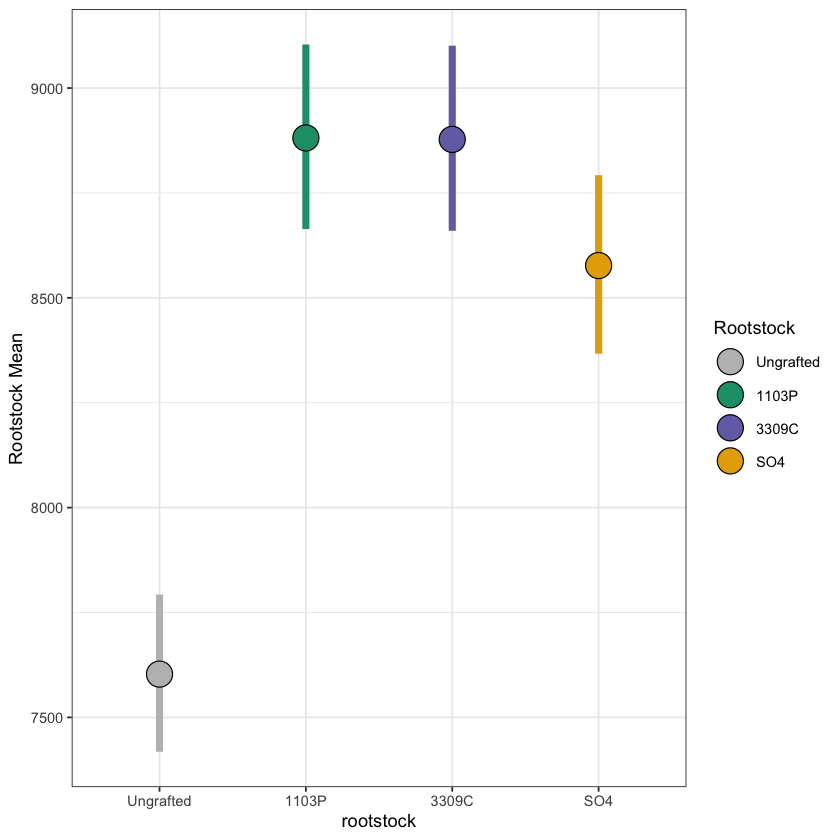

In [320]:
p <- emmeans::emmip(models[['K']], ~rootstock, plotit=F, CIs=T, data=datasets[['K']])
p$yvar <- exp(p$yvar * sds[['K']] + means[['K']])
p$LCL <- exp(p$LCL * sds[['K']] + means[['K']])
p$UCL <- exp(p$UCL * sds[['K']] + means[['K']])

ggplot(p, aes(x=rootstock, y=yvar, ymin=LCL, ymax=UCL, color=rootstock, fill=rootstock)) + 
  geom_linerange(lwd=2) + 
  scale_color_manual("Rootstock", values=rs_palette) + 
  geom_point(size=7, shape=21, color='black') + 
  scale_fill_manual("Rootstock", values=rs_palette) + 
  ylab(str_interp("Rootstock Mean")) + 
  theme_bw()

In [24]:
x <- 10000
for (i in 1:10){
    x <- x + x*0.06
}
x

[1] 17908.48

In [52]:
rootstocks <- c('Ungrafted', '1103P', '3309C', 'SO4')

for (i in 1:length(rootstocks)){
    for (j in 2:length(rootstocks))
        if (i != j & i < j){
            print(str_interp("${rootstocks[i]}-${rootstocks[j]}"))
        }
}

[1] "Ungrafted-1103P"
[1] "Ungrafted-3309C"
[1] "Ungrafted-SO4"
[1] "1103P-3309C"
[1] "1103P-SO4"
[1] "3309C-SO4"
